In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
from scipy.stats import norm
from scipy import optimize
from scipy.integrate import quad
#from sklearn import preprocessing
import calendar
import math
#from astropy import modeling
#import pylab as py

import imp
import os
import sys
sys.path.insert(0,'./support')

from ipynb.fs.defs.Sites import Site
from ipynb.fs.defs.Coordinates import Coordinates

#sys.path.insert(0, '..')
#from ipynb.fs.defs.Wave_Wind_site import Tp_to_Te

In [ ]:
# function copied directly from other notebooks

def Tp_to_Te(Tp,Hs):
    '''converts Tp to Te
    the equation for γ can be found in DNV-RP-C205 p.50 (3.5.5.5)
    Te = 2π M-1/M0 = Tp (4.2+γ)/(5+γ) (3.5.5.6)
    '''
    if Hs == 0 : γ = 1
    else:
        x = Tp/np.sqrt(Hs)
        if x < 3.6:
            γ = 5.
        elif x < 5:
            γ = np.exp(5.75 -1.15 * x)
        else: γ = 1.
    return Tp*(4.2+γ)/(5+γ)

In [ ]:
'''
# Function to add Energy column to dataframe
# If period is Tp, then calculates Te..
# Uses partial energy formula and calculates energy column.

#energy formula:
    #J = ρ * g**2 * Te * Hs**2 /(64*math.pi)
    
    #Te * Hs**2 is used..
    
# Assumes height is the first column and period is second...
'''
def energy_col(df, Te=False):
    df_new = df.copy(deep=True)
    hs_col = df.columns[0]
    t_col = df.columns[1]
    
    if Te==False:
        df_new['Te'] = df_new.apply(lambda x: Tp_to_Te(x[t_col],x[hs_col]),axis=1) 
        t_col = 'Te'
    
    df_new['Energy(Te*Hs**2)'] = df_new[t_col] * df_new[hs_col]**2

    return df_new

In [ ]:
'''
# Function to add delta columns by finding differences-delta values row by row.Takes dataframe as parameter

# Calls energy_col function to calculate energy column.

# Assumes height is the first column, period is second and Energy is the last one...
'''
def df_delta(df, Te=False):
    #directly assigning df is risky. All the updates made on df_new affects the df in the parameter.
    #copy func works fine for this. making deep param true copies index and the data and doesn't change df at all.
    df_new = df.copy(deep=True)
    
    hs_col = df.columns[0]
    t_col = df.columns[1]
    
    df_new = energy_col(df_new, Te)
    t_col = 'Te'
    
    enrgy = df_new[-1]
    df_new['▲Hs'] = df_new[hs_col].diff()
    df_new['▲Te'] = df_new[t_col].diff()
    df_new['▲Energy'] = enrgy.diff()
    df_new['▲Energy_relative'] = 2*(enrgy - enrgy.shift()) / (enrgy+enrgy.shift())
    #df['▲Energy(%)'] = df['Energy(T*Hs**2)'].pct_change(fill_method=None)
    #test=60
    #df_new['▲Energy_relativelow']=df_new['▲Energy_relative'].loc[(enrgy+enrgy.shift())/2<test]
    #df_new['▲Energy_relativehigh']=df_new['▲Energy_relative'].loc[(enrgy+enrgy.shift())/2>test]
    
    return df_new

In [ ]:
'''
Function to find one datasets' monthly avarage energy to be used to compare within the function 'df_monthly_comparison'
First calls energy_col function and resample TS df into monthly samples
Also gets missing value count and calculates the total time missing in the data such as 10 hours.

Assumes energy column is the last one..
'''
def df_monthly(df):
    df_monthly = pd.DataFrame()
    #df_res = df_delta(df)
    df_res = energy_col(df)
    
    df_res[df_res.columns[-1]] = df_res[df_res.columns[-1]].astype(float)
    #Take the column with partial energy value
    df_res = df_res[df_res.columns[-1]].resample('M')
    
    df_monthly['avg (Te*Hs**2)'] = df_res.mean()
    #to get the nan values, apply isna and resample again(it turns to series), and then sum monthly...
    #print(df_res.apply(pd.isna))
    interval = df.index[1]-df.index[0]
    nan_count = df_res.apply(pd.isna).resample('M').sum() * (interval)
    #convert nan count to hours.. from format like '1 days 20:00:00' to 44 hours..
    nan_count = nan_count.apply(lambda x: x.total_seconds()) / 3600
    df_monthly['missing hours(data_freq=' + str(df.index.freq) + ')'] = nan_count
    df_monthly.set_index(df_monthly.index.strftime('%B'), inplace=True)
    return df_monthly

In [106]:
(cdip.index.freq)

<30 * Minutes>

In [52]:
df_monthly(ndbc)

avg (Te*Hs**2)  total missing hours(data_freq=<30 * Minutes>)
January         64.394859                                           73.0
February        54.020917                                            4.5
March          102.181837                                           11.5
April           69.898194                                           12.5
May             53.541402                                            1.0
June            37.520307                                           35.5
July            31.867949                                           51.0
August          32.466239                                           19.5
September       41.542857                                          143.5
October         35.294882                                           75.5
November        57.974278                                           49.5
December        62.976070                                           55.5

In [17]:
df_monthly(ndbc)

avg (Te*Hs**2) missing data(freq=<30 * Minutes>)
January         64.394859                   3 days 01:00:00
February        54.020917                   0 days 04:30:00
March          102.181837                   0 days 11:30:00
April           69.898194                   0 days 12:30:00
May             53.541402                   0 days 01:00:00
June            37.520307                   1 days 11:30:00
July            31.867949                   2 days 03:00:00
August          32.466239                   0 days 19:30:00
September       41.542857                   5 days 23:30:00
October         35.294882                   3 days 03:30:00
November        57.974278                   2 days 01:30:00
December        62.976070                   2 days 07:30:00

In [20]:
df_monthly(ndbc2)

avg (Te*Hs**2) missing data(freq=<Hour>)
April           66.753149                  04:00:00
May             73.184960                  05:00:00
June            98.323047                  05:00:00
July            75.150253                  16:00:00
August          82.488576                  14:00:00
September       70.020829                  02:00:00
October         66.328944                  01:00:00
November        55.233072                  01:00:00
December        52.901319                  02:00:00

In [ ]:
'''
# monthly summary for energy comparison of two datasets...
# uses df_monthly func to get each dataset's monthly means and then merge them into a dataframe for comparison

# then, for each month, calculates:
        -Time interval/freq
        -nan value counts in df (total missing times)
        -mean energy differece 
        -variance
'''
def df_monthly_comparison(df_dict):
    df = pd.DataFrame()
    #intl = df_monthly(df_val)
    for key,df_val in df_dict.items():
        monthly = df_monthly(df_val)
        # both have two columns, energy and nan count
        df_avg = monthly[monthly.columns[0]]
        df_nan = monthly[monthly.columns[1]]
            
        if not df.empty:
            df[key + '_' + monthly.columns[1]] = df_nan
            df[key + '_avg_energy_diff(%)'] = ((df_avg - initial_avg) / initial_avg) * 100
            #df['avg_diff_mean-fraction'] = 2 * abs(df2_c1 - df1_c1) / (df1_c1 + df2_c1)
        else:
            df[key + '_' + monthly.columns[1]] = df_nan
            initial_avg = df_avg
    return df

In [23]:
df_monthly_comparison({'ndb' : ndbc, 'cd' : cdip, 'emo' : emodnet})

ndb_total missing hours(data_freq=<30 * Minutes>)  \
January                                                 73.0   
February                                                 4.5   
March                                                   11.5   
April                                                   12.5   
May                                                      1.0   
June                                                    35.5   
July                                                    51.0   
August                                                  19.5   
September                                              143.5   
October                                                 75.5   
November                                                49.5   
December                                                55.5   

           cd_total missing hours(data_freq=<30 * Minutes>)  \
January                                                71.5   
February                                                0.5   
March                                                  10.5   
April                                                   9.0   
May                                                     0.0   
June                                                   30.0   
July                                                   48.0   
August                                                  6.0   
September                                             106.0   
October                                                 0.0   
November                                                0.0   
December                                                0.0   

           cd_avg_energy_diff(%)  \
January                 0.062589   
February               -0.515218   
March                   0.110690   
April                  -0.220348   
May                    -0.119268   
June                   -0.192102   
July                    0.004678   
August                  0.856999   
September               0.502412   
October                -1.125768   
November                1.794878   
December               -0.524094   

           emo_total missing hours(data_freq=<30 * Minutes>)  \
January                                                 71.5   
February                                                 4.5   
March                                                   11.5   
April                                                   12.5   
May                                                      0.5   
June                                                    35.5   
July                                                   744.0   
August                                                  19.5   
September                                              142.5   
October                                                 73.5   
November                                                49.5   
December                                                55.5   

           emo_avg_energy_diff(%)  
January             -6.033513e-02  
February            -2.989520e-08  
March                1.520265e-07  
April                4.611642e-07  
May                 -2.801462e-02  
June                 2.978795e-08  
July                          NaN  
August              -1.263153e-07  
September           -3.437384e-02  
October              3.434910e-01  
November            -1.906647e-07  
December            -1.905777e-07

In [18]:
df_monthly_comparison({'ndb' : ndbc, 'cd' : cdip})

ndb_total missing hours(data_freq=<30 * Minutes>)  \
January                                                 73.0   
February                                                 4.5   
March                                                   11.5   
April                                                   12.5   
May                                                      1.0   
June                                                    35.5   
July                                                    51.0   
August                                                  19.5   
September                                              143.5   
October                                                 75.5   
November                                                49.5   
December                                                55.5   

           cd_total missing hours(data_freq=<30 * Minutes>)  \
January                                                71.5   
February                                                0.5   
March                                                  10.5   
April                                                   9.0   
May                                                     0.0   
June                                                   30.0   
July                                                   48.0   
August                                                  6.0   
September                                             106.0   
October                                                 0.0   
November                                                0.0   
December                                                0.0   

           avg_energy_diff(%)  
January              0.062589  
February            -0.515218  
March                0.110690  
April               -0.220348  
May                 -0.119268  
June                -0.192102  
July                 0.004678  
August               0.856999  
September            0.502412  
October             -1.125768  
November             1.794878  
December            -0.524094

In [57]:
df_monthly_comparison(ndbc,cdip)

1st data total missing time  2nd data total missing time  \
January                           73.0                         71.5   
February                           4.5                          0.5   
March                             11.5                         10.5   
April                             12.5                          9.0   
May                                1.0                          0.0   
June                              35.5                         30.0   
July                              51.0                         48.0   
August                            19.5                          6.0   
September                        143.5                        106.0   
October                           75.5                          0.0   
November                          49.5                          0.0   
December                          55.5                          0.0   

           avg_energy_diff  
January           0.000626  
February         -0.005152  
March             0.001107  
April            -0.002203  
May              -0.001193  
June             -0.001921  
July              0.000047  
August            0.008570  
September         0.005024  
October          -0.011258  
November          0.017949  
December         -0.005241

In [58]:
df_monthly_comparison(ndbc,emodnet)

1st data total missing time  2nd data total missing time  \
January                           73.0                         71.5   
February                           4.5                          4.5   
March                             11.5                         11.5   
April                             12.5                         12.5   
May                                1.0                          0.5   
June                              35.5                         35.5   
July                              51.0                        744.0   
August                            19.5                         19.5   
September                        143.5                        142.5   
October                           75.5                         73.5   
November                          49.5                         49.5   
December                          55.5                         55.5   

           avg_energy_diff  
January      -6.033513e-04  
February     -2.989520e-10  
March         1.520265e-09  
April         4.611642e-09  
May          -2.801462e-04  
June          2.978795e-10  
July                   NaN  
August       -1.263153e-09  
September    -3.437384e-04  
October       3.434910e-03  
November     -1.906647e-09  
December     -1.905777e-09

In [53]:
df_monthly_comparison(cdip,emodnet)

1st data total missing time  2nd data total missing time  \
January                           71.5                         71.5   
February                           0.5                          4.5   
March                             10.5                         11.5   
April                              9.0                         12.5   
May                                0.0                          0.5   
June                              30.0                         35.5   
July                              48.0                        744.0   
August                             6.0                         19.5   
September                        106.0                        142.5   
October                            0.0                         73.5   
November                           0.0                         49.5   
December                           0.0                         55.5   

           avg_energy_diff  
January           0.001228  
February          0.005179  
March             0.001106  
April             0.002208  
May               0.000914  
June              0.001925  
July                   NaN  
August            0.008497  
September         0.005341  
October           0.014860  
November          0.017632  
December          0.005269

In [26]:
df_monthly_comparison(cdip,emodnet)

1st data total missing time 2nd data total missing time  \
January               2 days 23:30:00             2 days 23:30:00   
February              0 days 00:30:00             0 days 04:30:00   
March                 0 days 10:30:00             0 days 11:30:00   
April                 0 days 09:00:00             0 days 12:30:00   
May                   0 days 00:00:00             0 days 00:30:00   
June                  1 days 06:00:00             1 days 11:30:00   
July                  2 days 00:00:00            31 days 00:00:00   
August                0 days 06:00:00             0 days 19:30:00   
September             4 days 10:00:00             5 days 22:30:00   
October               0 days 00:00:00             3 days 01:30:00   
November              0 days 00:00:00             2 days 01:30:00   
December              0 days 00:00:00             2 days 07:30:00   

           avg_energy_diff  
January           0.001228  
February          0.005179  
March             0.001106  
April             0.002208  
May               0.000914  
June              0.001925  
July                   NaN  
August            0.008497  
September         0.005341  
October           0.014860  
November          0.017632  
December          0.005269

In [59]:
df_monthly_comparison(ndbc2,emodnet)

1st data total missing time  2nd data total missing time  \
April                              4.0                         12.5   
May                                5.0                          0.5   
June                               5.0                         35.5   
July                              16.0                        744.0   
August                            14.0                         19.5   
September                          2.0                        142.5   
October                            1.0                         73.5   
November                           1.0                         49.5   
December                           2.0                         55.5   

           avg_energy_diff  
April             0.047115  
May              -0.268615  
June             -0.618398  
July                   NaN  
August           -0.606415  
September        -0.406911  
October          -0.466053  
November          0.049630  
December          0.190444

In [43]:
df_monthly_comparison(cdip,emodnet,'cd','emd')

cd nan  emd nan  avg_energy_diff
January     143.0    143.0         0.001228
February      1.0      9.0         0.005179
March        21.0     23.0         0.001106
April        18.0     25.0         0.002208
May           0.0      1.0         0.000914
June         60.0     71.0         0.001925
July         96.0   1488.0              NaN
August       12.0     39.0         0.008497
September   212.0    285.0         0.005341
October       0.0    147.0         0.014860
November      0.0     99.0         0.017632
December      0.0    111.0         0.005269

In [ ]:
start = '20110101'
end = '20111231'

In [ ]:
name='./EMODnet_Physics.ipynb'
get_ipython().run_line_magic('run', '$name')
emodnet = get_Emodnet_data(start,end,27683)

In [10]:
name='./California_CDIP.ipynb'
get_ipython().run_line_magic('run', '$name')
cdip = get_CDIP_data(start, end, 67)

fetching Wave data from the CDIP database
There are  563  missing data points out of  17520
We remove  3  points because they fall in a time interval where there already is data


In [11]:
name='./NDBC.ipynb'
get_ipython().run_line_magic('run', '$name')
ndbc = get_NDBC_data(start, end, 46219)
ndbc2 = get_NDBC_data(start, end, 32012)

fetching Wave data from the NDBC database
There are  146  missing data points out of  1488
There are  9  missing data points out of  1344
There are  23  missing data points out of  1488
There are  25  missing data points out of  1440
There are  2  missing data points out of  1488
There are  71  missing data points out of  1440
There are  102  missing data points out of  1488
There are  39  missing data points out of  1488
There are  287  missing data points out of  1440
There are  151  missing data points out of  1488
There are  99  missing data points out of  1440
There are  111  missing data points out of  1488
fetching Wave data from the NDBC database
There are  4  missing data points out of  412
These 2 dataframe do not have the same frequency and cannot be stitched together! None <Hour>
                           Hs(m)_NDBC32012  Tp(s)_NDBC32012
date_time                                                  
2011-04-13 20:00:00+00:00             1.89            12.12
2011-04-13 21:00:

In [42]:
def df_hist_old0(df):
    #number of charts
    k = len(df.columns)
    #number of chart columns for representing
    n = 3
    #number of chart rows for representing
    m = (k - 1) // n + 1
    #
    fig, axes = plt.subplots(m, n, figsize=(n * 6, m * 4))

    for i, (name, col) in enumerate(df.iteritems()):
        r, c = i // n, i % n
        ax = axes[r, c]
        ax.set_xlim(col.min(),col.max())
        col.hist(ax=ax,bins=50, density=True, stacked=True)
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
        ax2.set_ylim(0)

    #fig.suptitle('')
    plt.show()
    #fig.tight_layout()
    return

In [14]:
df_hist_old0(cd)

NameError: name 'cd' is not defined

In [15]:
# Monthly graphing of a given dataframe with delta values.
def df_hist_monthly(df, month_count=12):
    #group the data monthly. indexes are [1,12]...
    grouped = df.groupby(df.index.month)
    #
    #rowlength = grouped.ngroups
    
    #for every month
    for i in range(1,month_count+1):
        group = grouped.get_group(i)
        #if df.dropna().empty: group = pd.DataFrame()
        df_hist_test(group, monthly=True)
    return

In [16]:
# Monthly graphing of a given dataframe with delta values.
def df_hist_seasonal(df, season_count=4):
    lookup = {
        '11': 'Winter',
        '12': 'Winter',
        '1': 'Winter',
        '2': 'Spring',
        '3': 'Spring',
        '4': 'Spring',
        '5': 'Summer',
        '6': 'Summer',
        '7': 'Summer',
        '8': 'Autumn',
        '9': 'Autumn',
        '10': 'Autumn'
    }

    #months = (df.index).month
    #df['season'] = lookup.get(str(months))
    #print(df['season'])
    #df.drop('season', inplace=True, axis=1)
    grouped = df.groupby(df.index.month)
    #for every month
    for i in range(1,season_count + 1):
        j = i * 3 - 1 
    
        group = grouped.get_group(j)
        if j==11:
            df_new = pd.concat([group,grouped.get_group(j+1),grouped.get_group(1)], axis=0)
        else: 
            df_new = pd.concat([group,grouped.get_group(j+1),grouped.get_group(j+2)], axis=0)
        #df_new = group.merge(grouped.get_group(j+1), grouped.get_group(j+2))
        #print(df_new)
        #if df.dropna().empty: group = pd.DataFrame()
        df_hist_test(df_new)
        
    return


In [17]:
def gaussian(x, amp, mean, stddev):
    #amp = 1 / (stddev * math.sqrt(2 * math.pi))
    return amp * np.exp(-(((x.astype(float) - mean) / stddev)**2 / 2))

In [18]:
def Rayleigh(x, sigma):
    
    return (x / (sigma**2)) * np.exp(- (x**2) / (2 * (sigma**2)))

In [19]:
def Weibull(x, l, k):
    k=abs(k)
    l=abs(l)
    if l==0: return x * 0
    return (k/l) * ((x / l)**(k-1)) * np.exp(-(x/l)**k)

In [20]:
def chisquare(x, e):
    
    return sum(((x-e)**2)/e)

In [21]:
def df_hist_test(df, monthly=False): 
    #number of charts
    k = len(df.columns)
    #number of chart columns for representing
    fig_cols = 3
    #number of chart rows for representing
    m = (k - 1) // fig_cols + 1
    
    fig = plt.figure(figsize=(fig_cols * 6, m * 4))   #dpi=300
        
    for i, (name, col) in enumerate(df.iteritems()):       
        col=col.dropna()
        
        #Normalize the column
        #col = np.array(col)
        #col = preprocessing.normalize([col])

        ax = fig.add_subplot(m, fig_cols, i+1)
        #if df.dropna().empty: group = pd.DataFrame()
        if not (col.empty):
            col= col.astype(float)
            #normalize
            #col = (col - col.min()) / (col.max() - col.min())
            # Fit to normal distribution
            (mu, sigma) = stats.norm.fit(col)    ##same.. but not working when data contains nan values
            median = col.median()
            
            #col = (col-mu) / sigma
            ax.set_xlim(col.min(),col.max())
            
            # the histogram of the data
            n, bins, patches = ax.hist(col, bins=50, density=True)      #density/normed same..
            ax.axvline(x=0, color='r', linestyle='dashed', linewidth=2)       
            
            #bin_probability = n/float(n.sum())
            
            bin_width = bins[1]-bins[0]
            bins_middle = ((bins[1:]+bins[:-1])/2)
            
            bin_count = len(bins)-1
            
            #scaling_factor = len(col) * (col.max()-col.min())/bin_count
            #########
            #amp = 1 / (sigma * math.sqrt(2 * math.pi))
            amp = n.max()
            #modelling produse same as norm.pdf

            #mdl = modeling.models.Gaussian1D(amplitude=amp, mean=mu, stddev=sigma)
            #data = mdl(col)
            #popt, covar = optimize.curve_fit(gaussian, col, data)
            
            #fitter = modeling.fitting.LevMarLSQFitter()
            #fitted_mdl = fitter(mdl, col, data)
            #plt.plot(bins_middle, fitted_mdl(bins_middle))
            
            popt, pcov = optimize.curve_fit(gaussian, bins_middle, n, p0=[amp, mu, sigma])
            #, bound=[(0,np.inf),(0,np.inf),(0,np.inf)]
            #plt.plot(n)
            
            #x_fit = py.linspace(bins_middle[0], bins_middle[-1], 100)
            gauss = gaussian(bins_middle, *popt)
            plt.plot(bins_middle, gauss, lw=2, label='X^2= ' + str(round(stats.chisquare(n,gauss)[0],3)))

            #this produce the same as analytical pdf - norm.pdf (new params are not created)
            #gauss2 = gaussian(bins_middle, amp, mu, sigma)
            #plt.plot(bins_middle, gauss2, lw=2, label=stats.chisquare(n,gauss2)[0])

            #x = np.linspace(col.min(), col.max(), 100)

            #Analytical (True) PDF
            # add a 'best fit' line
            #The probability density function for norm is: f(x)= exp(-x**2/2) / sqrt(2 * math.pi) (standardized form.. use loc, scale params)
            y = norm.pdf(bins_middle, mu, sigma)   
            ###
            ###
            #bin_width = (max(bins_middle) - min(bins_middle)) / len(bins)
            
            #to un-normalize the distribution
            #y = y * (len(col) * bin_width)
            
            ax2 = ax.plot(bins_middle, y, 'r--', linewidth=2, label='X^2= ' + str(round(stats.chisquare(n,y)[0],3)))
            #print(np.trapz(bins, y))  #area under curve
            
            #PDF Estimated via KDE
            y2=stats.gaussian_kde(col)
            ax.plot(bins_middle, y2.evaluate(bins_middle), c='black', lw=2, label='X^2= ' + str(round(stats.chisquare(n,y2.evaluate(bins_middle))[0],3)))
            
            #chi = stats.chisquare(n,y)  
            #print(chi)
            #chi = stats.chisquare(n,y2.evaluate(bins_middle))  
            #print(chi)
            #chi = stats.chisquare(col,norm.pdf(col, mu, sigma))
            ax.set_title(name + ' \n skw= ' + str(round(stats.skew(col),3)) + ' krts= ' + str(round(stats.kurtosis(col),3)) 
                         + ' \n mu=' + str(round(mu,2)) + ' std=' + str(round(sigma,2))
                         + ' \n popt(mu,std) =' + str(popt.round(2)))
            
            plt.legend(prop={'size': 8})

    #if len(df.groupby(df.index.month)) == 1:
    if(monthly == True):
        fig.suptitle(str(calendar.month_abbr[(df.index.month)[0]]), fontsize=16)
    else:
        fig.suptitle('Annual charts for all columns', fontsize=16)
    #plt.show()
    fig.tight_layout(pad=5.0)
    return

In [24]:
#different buoy unique to ndbc db

nd2 = df_delta(ndbc2)
nd2

Hs(m)_NDBC32012 Tp(s)_NDBC32012      Te   ▲Hs  \
date_time                                                                 
2011-04-13 20:00:00+00:00            1.89           12.12  10.504   NaN   
2011-04-13 21:00:00+00:00            1.89           12.12  10.504     0   
2011-04-13 22:00:00+00:00            1.77            12.9  11.180 -0.12   
2011-04-13 23:00:00+00:00            1.79           12.12  10.504  0.02   
2011-04-14 00:00:00+00:00            1.67            12.9  11.180 -0.12   
...                                   ...             ...     ...   ...   
2011-12-31 19:00:00+00:00            1.72           12.12  10.504  0.08   
2011-12-31 20:00:00+00:00            1.75           12.12  10.504  0.03   
2011-12-31 21:00:00+00:00            1.72           11.43   9.906 -0.03   
2011-12-31 22:00:00+00:00             1.6           11.43   9.906 -0.12   
2011-12-31 23:00:00+00:00            1.74           11.43   9.906  0.14   

                             ▲Te Energy(Te*Hs**2)  ▲Energy ▲Energy_relative  \
date_time                                                                     
2011-04-13 20:00:00+00:00    NaN          37.5213      NaN              NaN   
2011-04-13 21:00:00+00:00  0.000          37.5213        0                0   
2011-04-13 22:00:00+00:00  0.676          35.0258 -2.49552       -0.0687971   
2011-04-13 23:00:00+00:00 -0.676          33.6559 -1.36996       -0.0398929   
2011-04-14 00:00:00+00:00  0.676          31.1799 -2.47596       -0.0763765   
...                          ...              ...      ...              ...   
2011-12-31 19:00:00+00:00 -0.676           31.075  1.00531        0.0328828   
2011-12-31 20:00:00+00:00  0.000          32.1685  1.09347        0.0345795   
2011-12-31 21:00:00+00:00 -0.598          29.3059 -2.86259       -0.0931311   
2011-12-31 22:00:00+00:00  0.000          25.3594 -3.94655         -0.14439   
2011-12-31 23:00:00+00:00  0.000          29.9914  4.63205         0.167371   

                          ▲Energy_relativelow ▲Energy_relativehigh  
date_time                                                           
2011-04-13 20:00:00+00:00                 NaN                  NaN  
2011-04-13 21:00:00+00:00                   0                  NaN  
2011-04-13 22:00:00+00:00          -0.0687971                  NaN  
2011-04-13 23:00:00+00:00          -0.0398929                  NaN  
2011-04-14 00:00:00+00:00          -0.0763765                  NaN  
...                                       ...                  ...  
2011-12-31 19:00:00+00:00           0.0328828                  NaN  
2011-12-31 20:00:00+00:00           0.0345795                  NaN  
2011-12-31 21:00:00+00:00          -0.0931311                  NaN  
2011-12-31 22:00:00+00:00            -0.14439                  NaN  
2011-12-31 23:00:00+00:00            0.167371                  NaN  

[6292 rows x 10 columns]

In [22]:
nd = df_delta(ndbc)
nd

Hs(m)_NDBC46219 Tp(s)_NDBC46219         Te   ▲Hs  \
date_time                                                                    
2011-01-01 00:00:00+00:00            2.02           11.76  10.192000   NaN   
2011-01-01 00:30:00+00:00            2.03           10.53   9.126000  0.01   
2011-01-01 01:00:00+00:00             2.1           10.53   9.126000  0.07   
2011-01-01 01:30:00+00:00            1.97           10.53   9.126000 -0.13   
2011-01-01 02:00:00+00:00             2.1           11.76  10.192000  0.13   
...                                   ...             ...        ...   ...   
2011-12-31 21:30:00+00:00            2.51           15.38  13.329333 -0.04   
2011-12-31 22:00:00+00:00            2.56           15.38  13.329333  0.05   
2011-12-31 22:30:00+00:00            2.33           13.33  11.552667 -0.23   
2011-12-31 23:00:00+00:00            2.64           15.38  13.329333  0.31   
2011-12-31 23:30:00+00:00             2.5           15.38  13.329333 -0.14   

                                ▲Te Energy(T*Hs**2)  ▲Energy ▲Energy_relative  \
date_time                                                                       
2011-01-01 00:00:00+00:00       NaN         41.5874      NaN              NaN   
2011-01-01 00:30:00+00:00 -1.066000         37.6073  -3.9801        -0.100514   
2011-01-01 01:00:00+00:00  0.000000         40.2457  2.63833        0.0677771   
2011-01-01 01:30:00+00:00  0.000000         35.4171 -4.82857        -0.127634   
2011-01-01 02:00:00+00:00  1.066000         44.9467  9.52963         0.237162   
...                             ...             ...      ...              ...   
2011-12-31 21:30:00+00:00  0.000000         83.9761 -2.69786       -0.0316186   
2011-12-31 22:00:00+00:00  0.000000         87.3551  3.37899        0.0394439   
2011-12-31 22:30:00+00:00 -1.776667         62.7183 -24.6368        -0.328331   
2011-12-31 23:00:00+00:00  1.776667         92.9001  30.1818         0.387896   
2011-12-31 23:30:00+00:00  0.000000         83.3083 -9.59179        -0.108869   

                          ▲Energy_relativelow ▲Energy_relativehigh  
date_time                                                           
2011-01-01 00:00:00+00:00                 NaN                  NaN  
2011-01-01 00:30:00+00:00           -0.100514                  NaN  
2011-01-01 01:00:00+00:00           0.0677771                  NaN  
2011-01-01 01:30:00+00:00           -0.127634                  NaN  
2011-01-01 02:00:00+00:00            0.237162                  NaN  
...                                       ...                  ...  
2011-12-31 21:30:00+00:00                 NaN           -0.0316186  
2011-12-31 22:00:00+00:00                 NaN            0.0394439  
2011-12-31 22:30:00+00:00                 NaN            -0.328331  
2011-12-31 23:00:00+00:00                 NaN             0.387896  
2011-12-31 23:30:00+00:00                 NaN            -0.108869  

[17520 rows x 10 columns]

In [23]:
cd = df_delta(cdip)
cd

Hs(m)_CDIP67  Tp(s)_CDIP67         Te   ▲Hs  \
Time (UTC)                                                               
2011-01-01 00:00:00+00:00          2.03         10.53   9.126000   NaN   
2011-01-01 00:30:00+00:00          2.10         10.53   9.126000  0.07   
2011-01-01 01:00:00+00:00          1.97         10.53   9.126000 -0.13   
2011-01-01 01:30:00+00:00          2.10         11.76  10.192000  0.13   
2011-01-01 02:00:00+00:00          1.99         10.53   9.126000 -0.11   
...                                 ...           ...        ...   ...   
2011-12-31 21:30:00+00:00          2.51         15.38  13.329333 -0.04   
2011-12-31 22:00:00+00:00          2.56         15.38  13.329333  0.05   
2011-12-31 22:30:00+00:00          2.33         13.33  11.552667 -0.23   
2011-12-31 23:00:00+00:00          2.64         15.38  13.329333  0.31   
2011-12-31 23:30:00+00:00          2.50         15.38  13.329333 -0.14   

                                ▲Te  Energy(T*Hs**2)    ▲Energy  \
Time (UTC)                                                        
2011-01-01 00:00:00+00:00       NaN        37.607333        NaN   
2011-01-01 00:30:00+00:00  0.000000        40.245660   2.638327   
2011-01-01 01:00:00+00:00  0.000000        35.417093  -4.828567   
2011-01-01 01:30:00+00:00  1.066000        44.946720   9.529627   
2011-01-01 02:00:00+00:00 -1.066000        36.139873  -8.806847   
...                             ...              ...        ...   
2011-12-31 21:30:00+00:00  0.000000        83.976133  -2.697857   
2011-12-31 22:00:00+00:00  0.000000        87.355119   3.378986   
2011-12-31 22:30:00+00:00 -1.776667        62.718272 -24.636847   
2011-12-31 23:00:00+00:00  1.776667        92.900122  30.181850   
2011-12-31 23:30:00+00:00  0.000000        83.308333  -9.591788   

                           ▲Energy_relative  ▲Energy_relativelow  \
Time (UTC)                                                         
2011-01-01 00:00:00+00:00               NaN                  NaN   
2011-01-01 00:30:00+00:00          0.067777             0.067777   
2011-01-01 01:00:00+00:00         -0.127634            -0.127634   
2011-01-01 01:30:00+00:00          0.237162             0.237162   
2011-01-01 02:00:00+00:00         -0.217221            -0.217221   
...                                     ...                  ...   
2011-12-31 21:30:00+00:00         -0.031619                  NaN   
2011-12-31 22:00:00+00:00          0.039444                  NaN   
2011-12-31 22:30:00+00:00         -0.328331                  NaN   
2011-12-31 23:00:00+00:00          0.387896                  NaN   
2011-12-31 23:30:00+00:00         -0.108869                  NaN   

                           ▲Energy_relativehigh  
Time (UTC)                                       
2011-01-01 00:00:00+00:00                   NaN  
2011-01-01 00:30:00+00:00                   NaN  
2011-01-01 01:00:00+00:00                   NaN  
2011-01-01 01:30:00+00:00                   NaN  
2011-01-01 02:00:00+00:00                   NaN  
...                                         ...  
2011-12-31 21:30:00+00:00             -0.031619  
2011-12-31 22:00:00+00:00              0.039444  
2011-12-31 22:30:00+00:00             -0.328331  
2011-12-31 23:00:00+00:00              0.387896  
2011-12-31 23:30:00+00:00             -0.108869  

[17520 rows x 10 columns]

In [24]:
#after tp_to_te
emd = df_delta(emodnet)
emd

Hs(m)_Emodnet(vhm0)_27683  \
time (UTC)                                             
2011-01-01 00:00:00+00:00                       2.02   
2011-01-01 00:30:00+00:00                       2.03   
2011-01-01 01:00:00+00:00                       2.10   
2011-01-01 01:30:00+00:00                       1.97   
2011-01-01 02:00:00+00:00                       2.10   
...                                              ...   
2011-12-31 21:30:00+00:00                       2.51   
2011-12-31 22:00:00+00:00                       2.56   
2011-12-31 22:30:00+00:00                       2.33   
2011-12-31 23:00:00+00:00                       2.64   
2011-12-31 23:30:00+00:00                       2.50   

                           T(s)_Emodnet(VTPK)_27683         Te   ▲Hs  \
time (UTC)                                                             
2011-01-01 00:00:00+00:00                     11.76  10.192000   NaN   
2011-01-01 00:30:00+00:00                     10.53   9.126000  0.01   
2011-01-01 01:00:00+00:00                     10.53   9.126000  0.07   
2011-01-01 01:30:00+00:00                     10.53   9.126000 -0.13   
2011-01-01 02:00:00+00:00                     11.76  10.192000  0.13   
...                                             ...        ...   ...   
2011-12-31 21:30:00+00:00                     15.38  13.329333 -0.04   
2011-12-31 22:00:00+00:00                     15.38  13.329333  0.05   
2011-12-31 22:30:00+00:00                     13.33  11.552667 -0.23   
2011-12-31 23:00:00+00:00                     15.38  13.329333  0.31   
2011-12-31 23:30:00+00:00                     15.38  13.329333 -0.14   

                                ▲Te  Energy(T*Hs**2)    ▲Energy  \
time (UTC)                                                        
2011-01-01 00:00:00+00:00       NaN        41.587437        NaN   
2011-01-01 00:30:00+00:00 -1.066000        37.607331  -3.980105   
2011-01-01 01:00:00+00:00  0.000000        40.245655   2.638324   
2011-01-01 01:30:00+00:00  0.000000        35.417094  -4.828562   
2011-01-01 02:00:00+00:00  1.066000        44.946717   9.529623   
...                             ...              ...        ...   
2011-12-31 21:30:00+00:00  0.000000        83.976133  -2.697854   
2011-12-31 22:00:00+00:00  0.000000        87.355116   3.378983   
2011-12-31 22:30:00+00:00 -1.776667        62.718268 -24.636848   
2011-12-31 23:00:00+00:00  1.776667        92.900130  30.181862   
2011-12-31 23:30:00+00:00  0.000000        83.308334  -9.591796   

                           ▲Energy_relative  ▲Energy_relativelow  \
time (UTC)                                                         
2011-01-01 00:00:00+00:00               NaN                  NaN   
2011-01-01 00:30:00+00:00         -0.100514            -0.100514   
2011-01-01 01:00:00+00:00          0.067777             0.067777   
2011-01-01 01:30:00+00:00         -0.127634            -0.127634   
2011-01-01 02:00:00+00:00          0.237162             0.237162   
...                                     ...                  ...   
2011-12-31 21:30:00+00:00         -0.031619                  NaN   
2011-12-31 22:00:00+00:00          0.039444                  NaN   
2011-12-31 22:30:00+00:00         -0.328331                  NaN   
2011-12-31 23:00:00+00:00          0.387896                  NaN   
2011-12-31 23:30:00+00:00         -0.108869                  NaN   

                           ▲Energy_relativehigh  
time (UTC)                                       
2011-01-01 00:00:00+00:00                   NaN  
2011-01-01 00:30:00+00:00                   NaN  
2011-01-01 01:00:00+00:00                   NaN  
2011-01-01 01:30:00+00:00                   NaN  
2011-01-01 02:00:00+00:00                   NaN  
...                                         ...  
2011-12-31 21:30:00+00:00             -0.031619  
2011-12-31 22:00:00+00:00              0.039444  
2011-12-31 22:30:00+00:00             -0.328331  
2011-12-31 23:00:00+00:00              0.387896  
2011

In [18]:
#before tp_to_te
emd = df_delta(emodnet)
emd

Hs(m)_Emodnet(vhm0)_27683  \
time (UTC)                                             
2011-01-01 00:00:00+00:00                       2.02   
2011-01-01 00:30:00+00:00                       2.03   
2011-01-01 01:00:00+00:00                       2.10   
2011-01-01 01:30:00+00:00                       1.97   
2011-01-01 02:00:00+00:00                       2.10   
...                                              ...   
2011-12-31 21:30:00+00:00                       2.51   
2011-12-31 22:00:00+00:00                       2.56   
2011-12-31 22:30:00+00:00                       2.33   
2011-12-31 23:00:00+00:00                       2.64   
2011-12-31 23:30:00+00:00                       2.50   

                           T(s)_Emodnet(VTPK)_27683   ▲Hs    ▲T  \
time (UTC)                                                        
2011-01-01 00:00:00+00:00                     11.76   NaN   NaN   
2011-01-01 00:30:00+00:00                     10.53  0.01 -1.23   
2011-01-01 01:00:00+00:00                     10.53  0.07  0.00   
2011-01-01 01:30:00+00:00                     10.53 -0.13  0.00   
2011-01-01 02:00:00+00:00                     11.76  0.13  1.23   
...                                             ...   ...   ...   
2011-12-31 21:30:00+00:00                     15.38 -0.04  0.00   
2011-12-31 22:00:00+00:00                     15.38  0.05  0.00   
2011-12-31 22:30:00+00:00                     13.33 -0.23 -2.05   
2011-12-31 23:00:00+00:00                     15.38  0.31  2.05   
2011-12-31 23:30:00+00:00                     15.38 -0.14  0.00   

                           Energy(T*Hs**2)    ▲Energy  ▲Energy_relative  \
time (UTC)                                                                
2011-01-01 00:00:00+00:00        47.985504        NaN               NaN   
2011-01-01 00:30:00+00:00        43.393075  -4.592429         -0.100514   
2011-01-01 01:00:00+00:00        46.437295   3.044220          0.067777   
2011-01-01 01:30:00+00:00        40.865877  -5.571417         -0.127634   
2011-01-01 02:00:00+00:00        51.861596  10.995719          0.237162   
...                                    ...        ...               ...   
2011-12-31 21:30:00+00:00        96.895538  -3.112909         -0.031619   
2011-12-31 22:00:00+00:00       100.794364   3.898826          0.039444   
2011-12-31 22:30:00+00:00        72.367232 -28.427132         -0.328331   
2011-12-31 23:00:00+00:00       107.192457  34.825225          0.387896   
2011-12-31 23:30:00+00:00        96.125001 -11.067457         -0.108869   

                           ▲Energy_relativelow  ▲Energy_relativehigh  
time (UTC)                                                            
2011-01-01 00:00:00+00:00                  NaN                   NaN  
2011-01-01 00:30:00+00:00            -0.100514                   NaN  
2011-01-01 01:00:00+00:00             0.067777                   NaN  
2011-01-01 01:30:00+00:00            -0.127634                   NaN  
2011-01-01 02:00:00+00:00             0.237162                   NaN  
...                                        ...                   ...  
2011-12-31 21:30:00+00:00                  NaN             -0.031619  
2011-12-31 22:00:00+00:00                  NaN              0.039444  
2011-12-31 22:30:00+00:00                  NaN             -0.328331  
2011-12-31 23:00:00+00:00                  NaN              0.387896  
2011-12-31 23:30:00+00:00                  NaN             -0.108869  

[17520 rows x 9 columns]

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: overflow encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


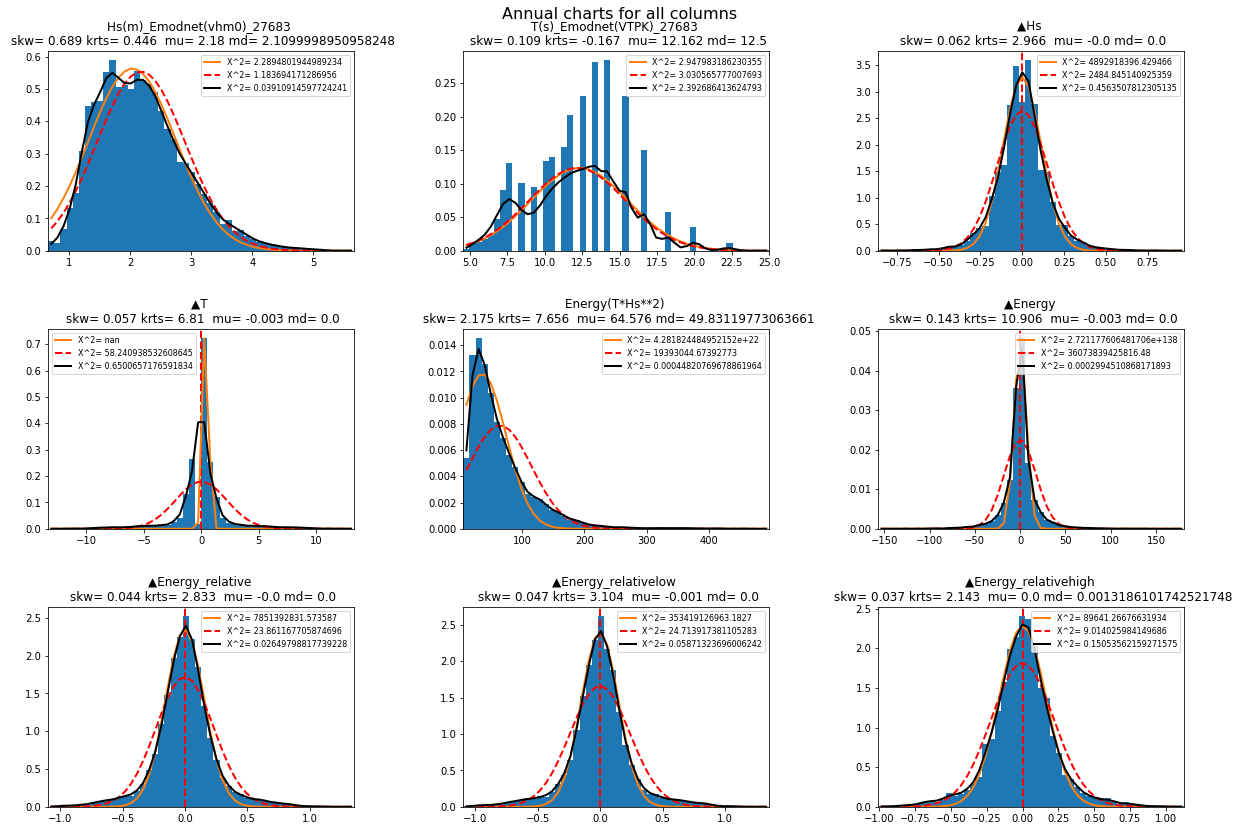

In [19]:
df_hist_test(emd)

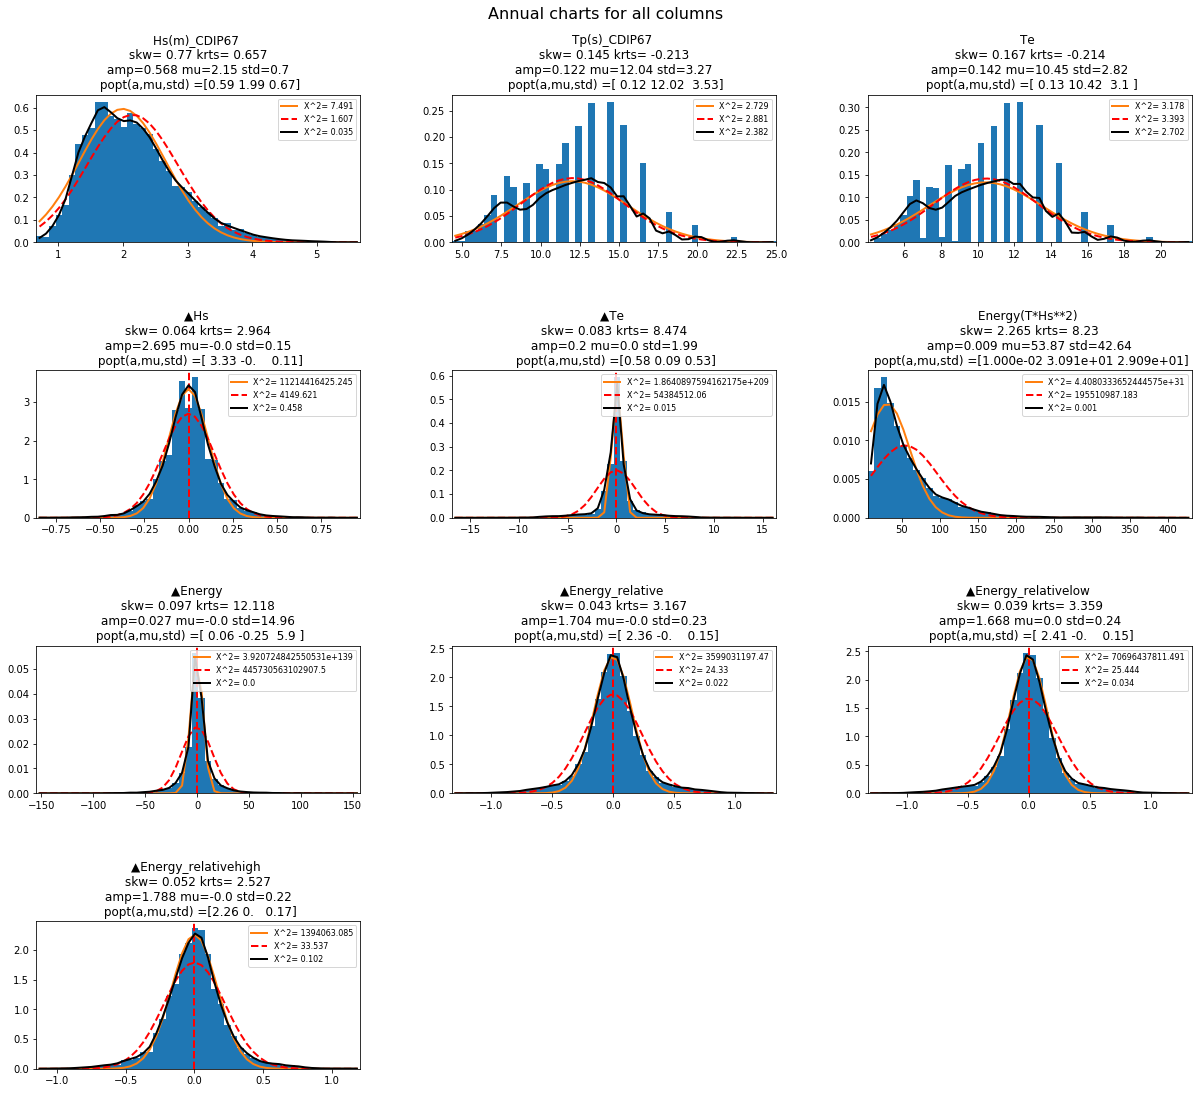

In [49]:
#after Tp_to_Te
#annual histogramming 

df_hist_test(cd)

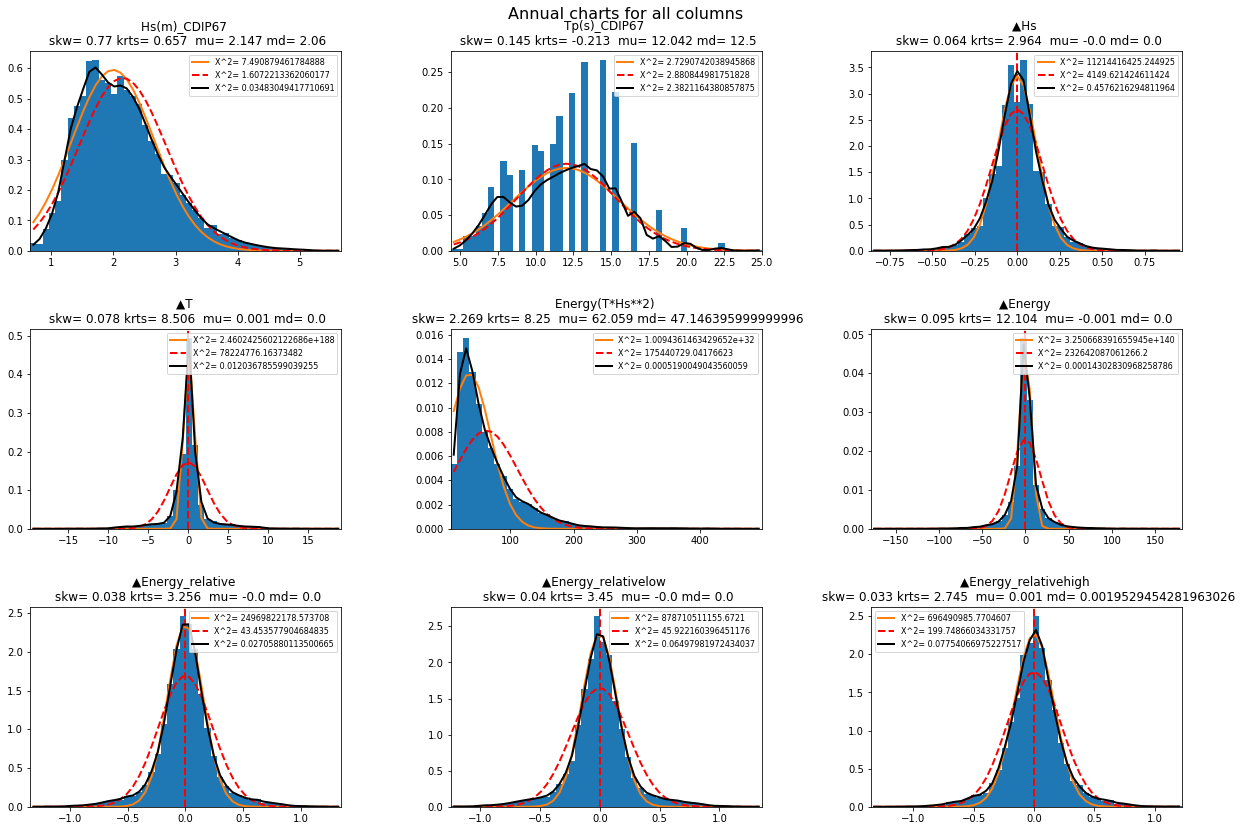

In [15]:
#before Tp_to_Te
#annual histogramming

df_hist_test(cd)

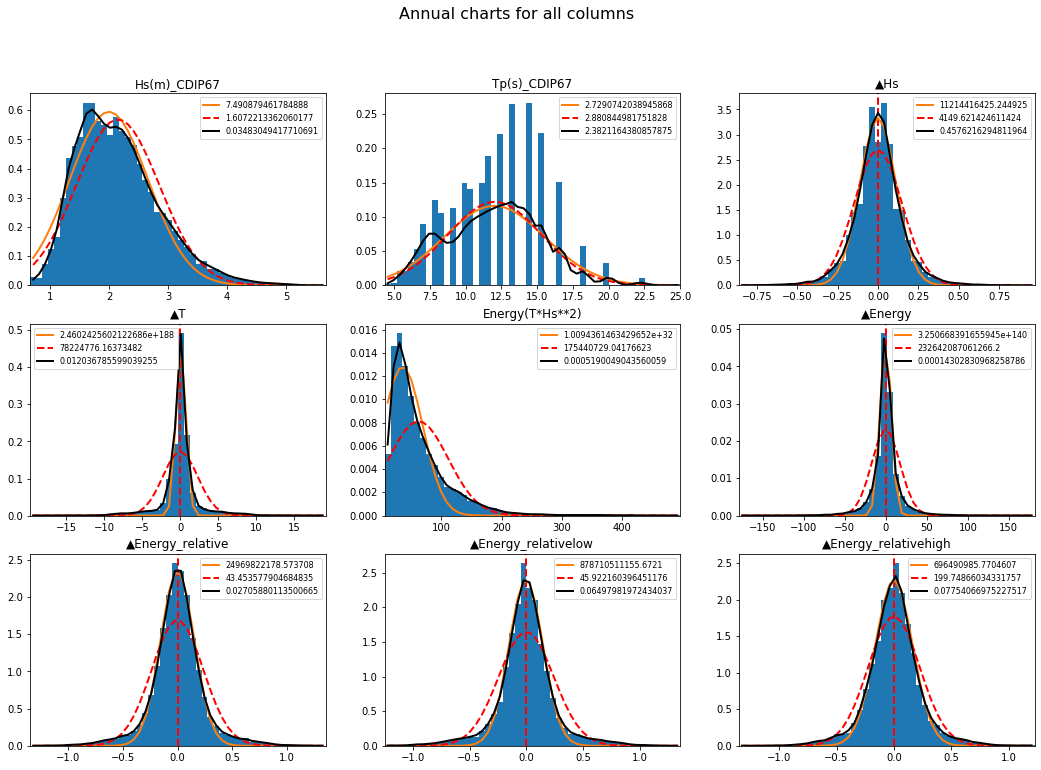

In [59]:
#before Tp_to_Te
#annual histogramming 

df_hist_test(cd)

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


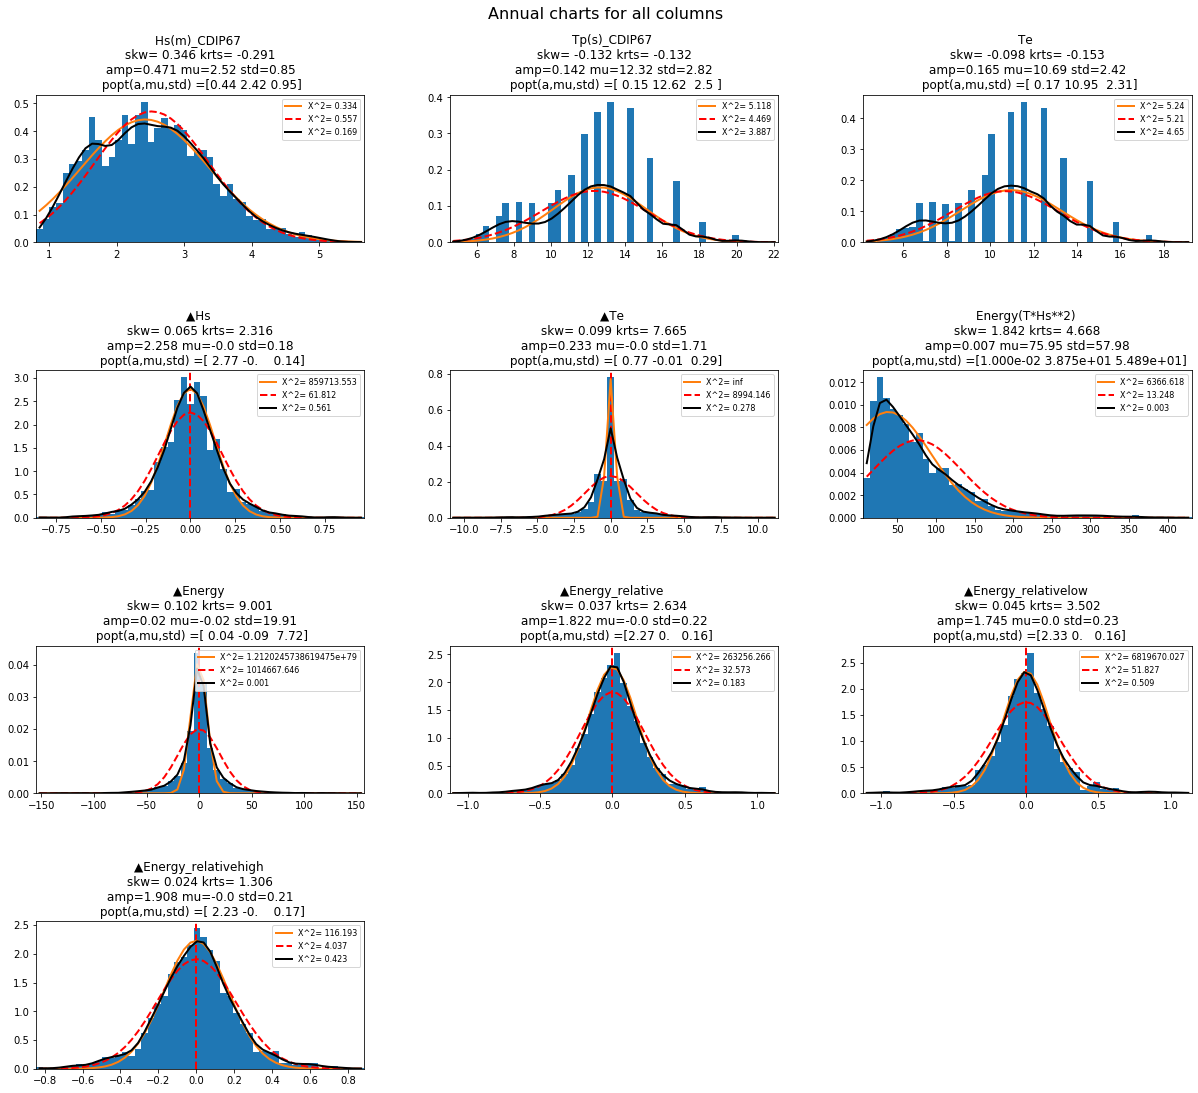

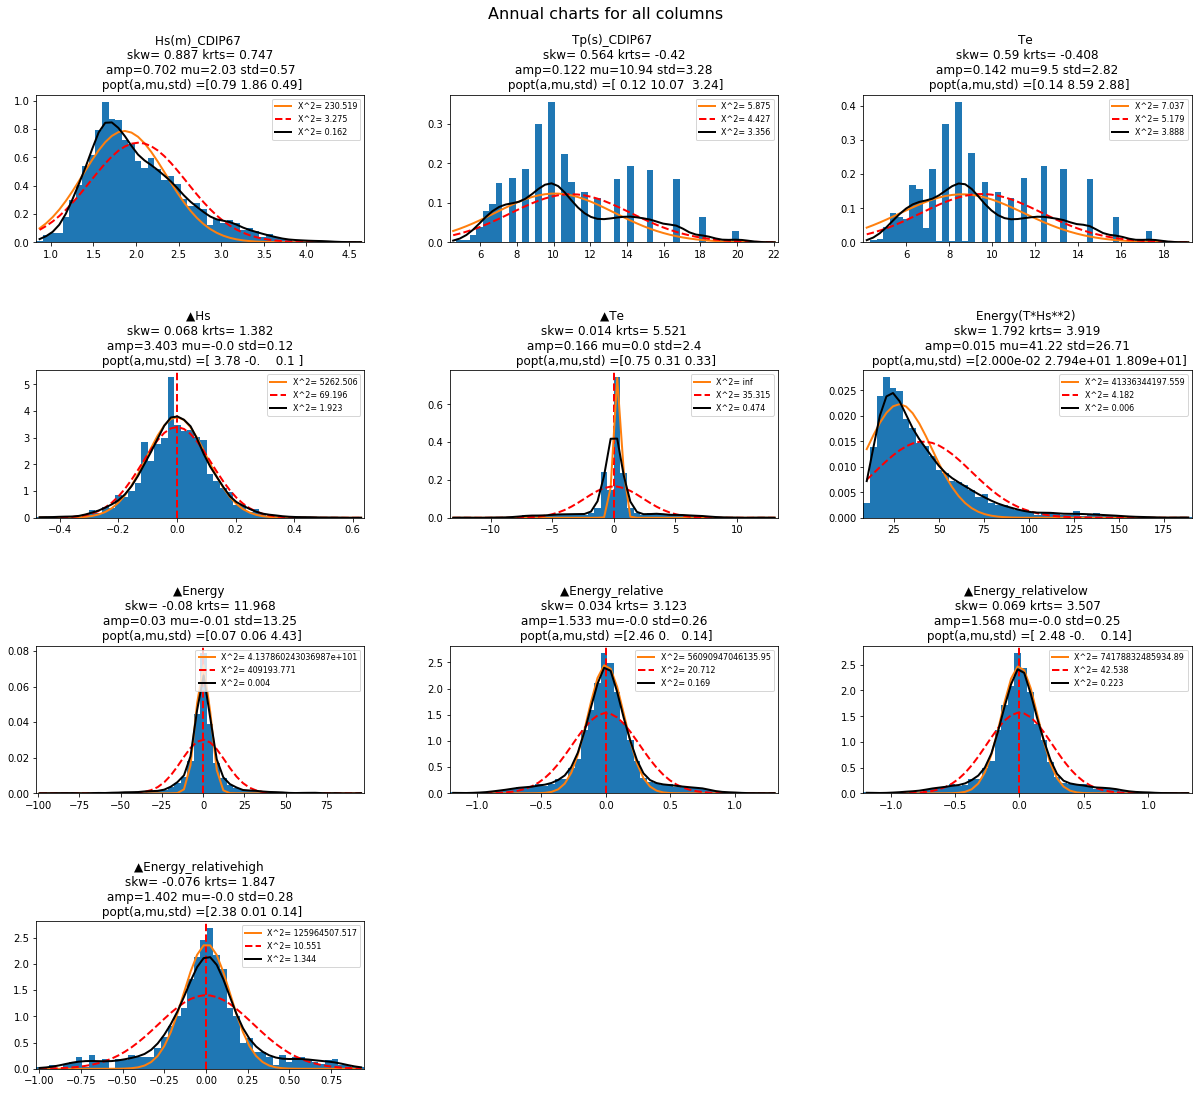

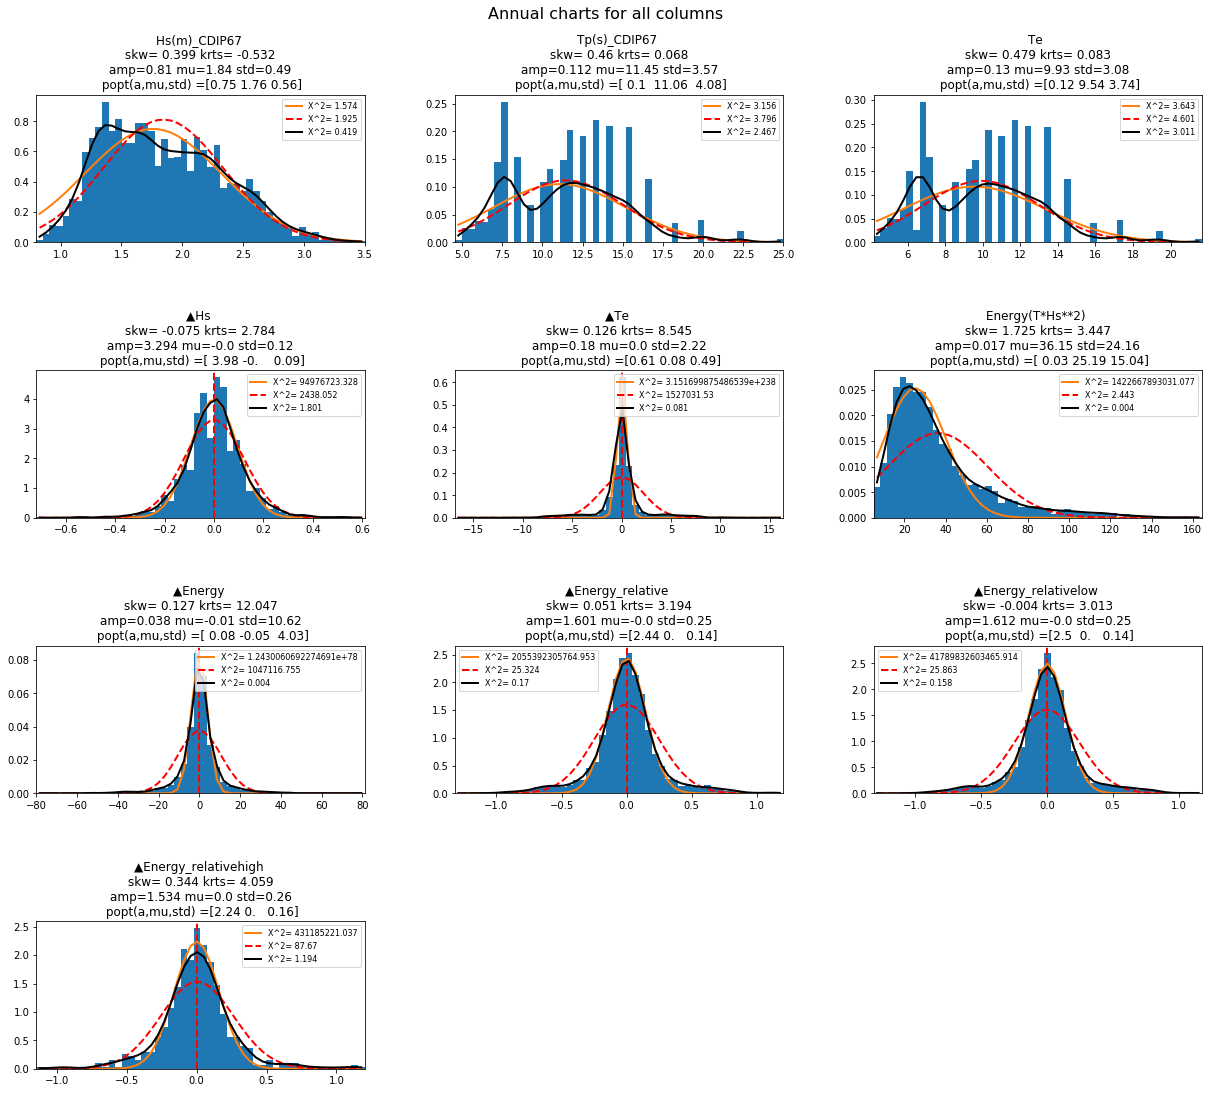

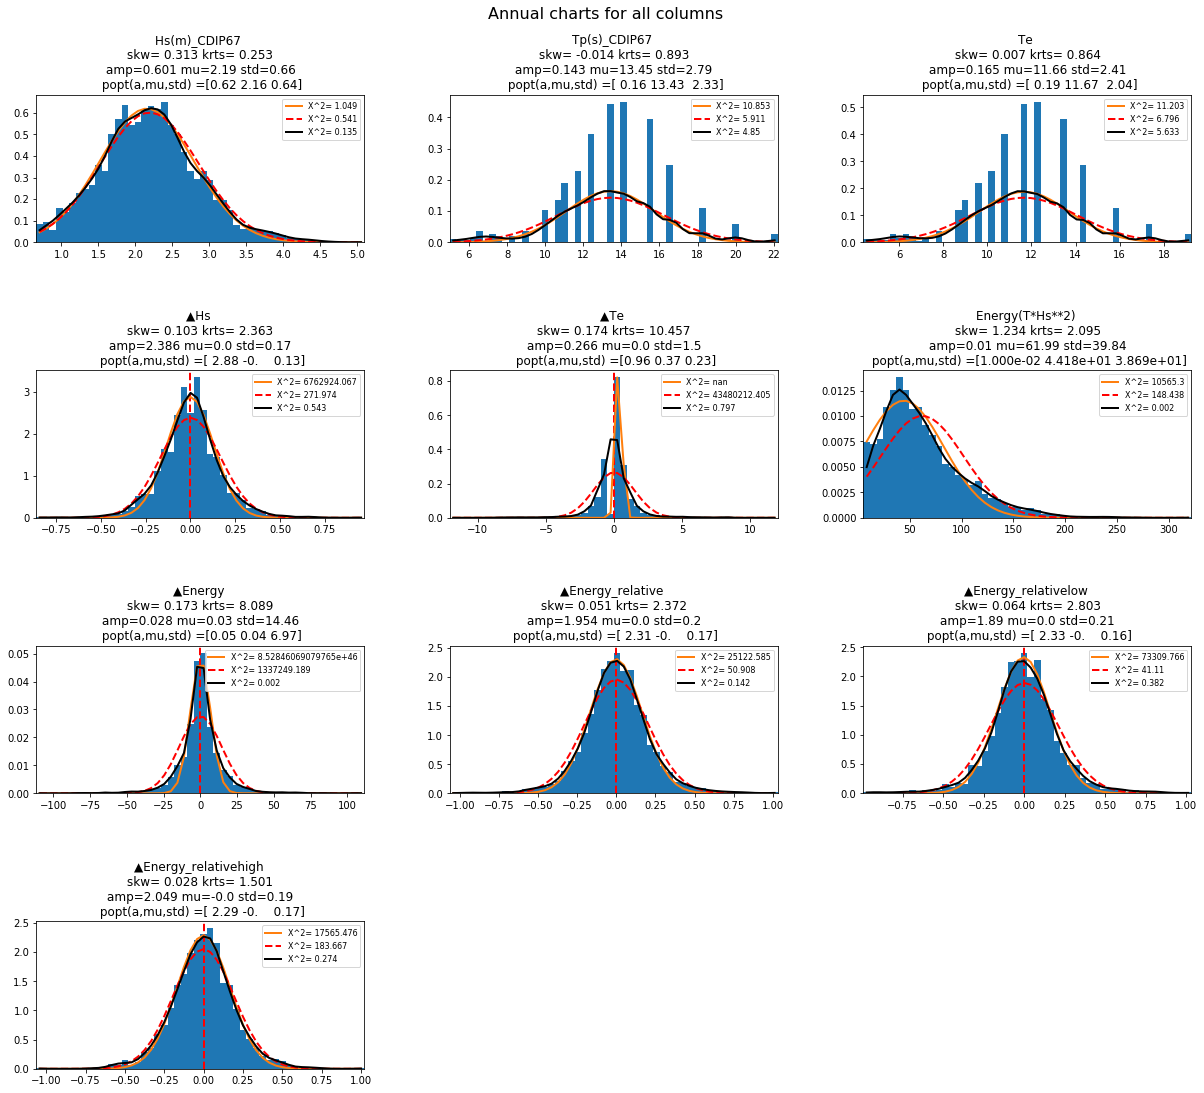

In [53]:
#after tp_to_te
#seasonal histogramming 

df_hist_seasonal(cd)

2


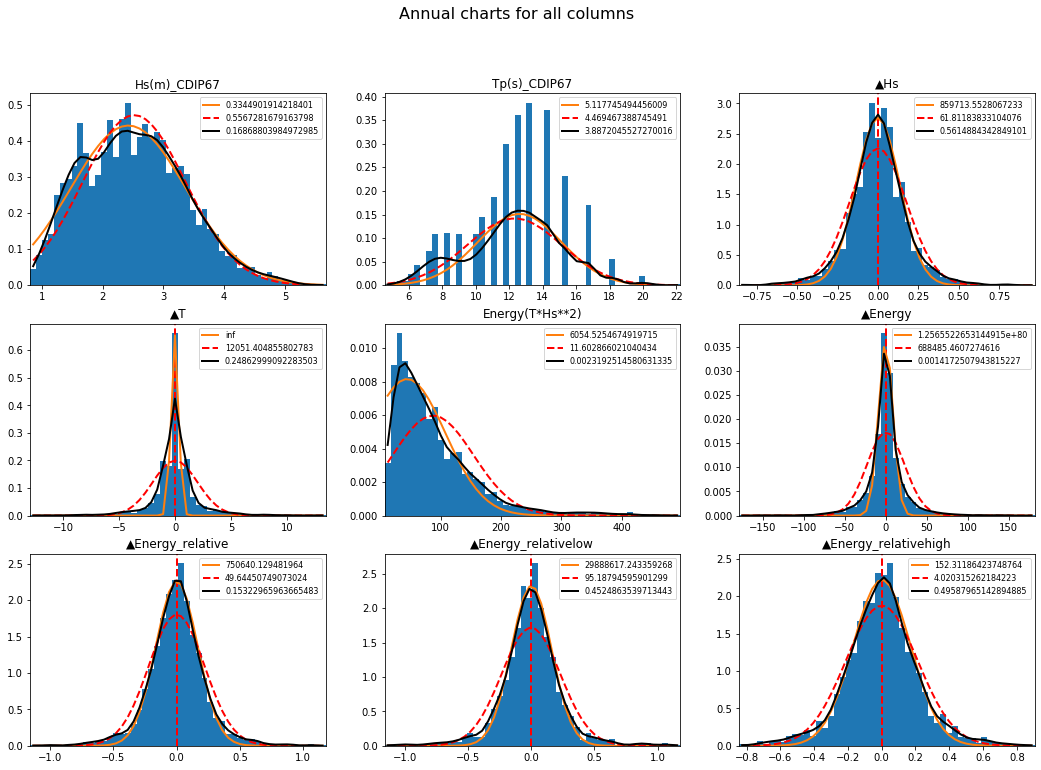

5


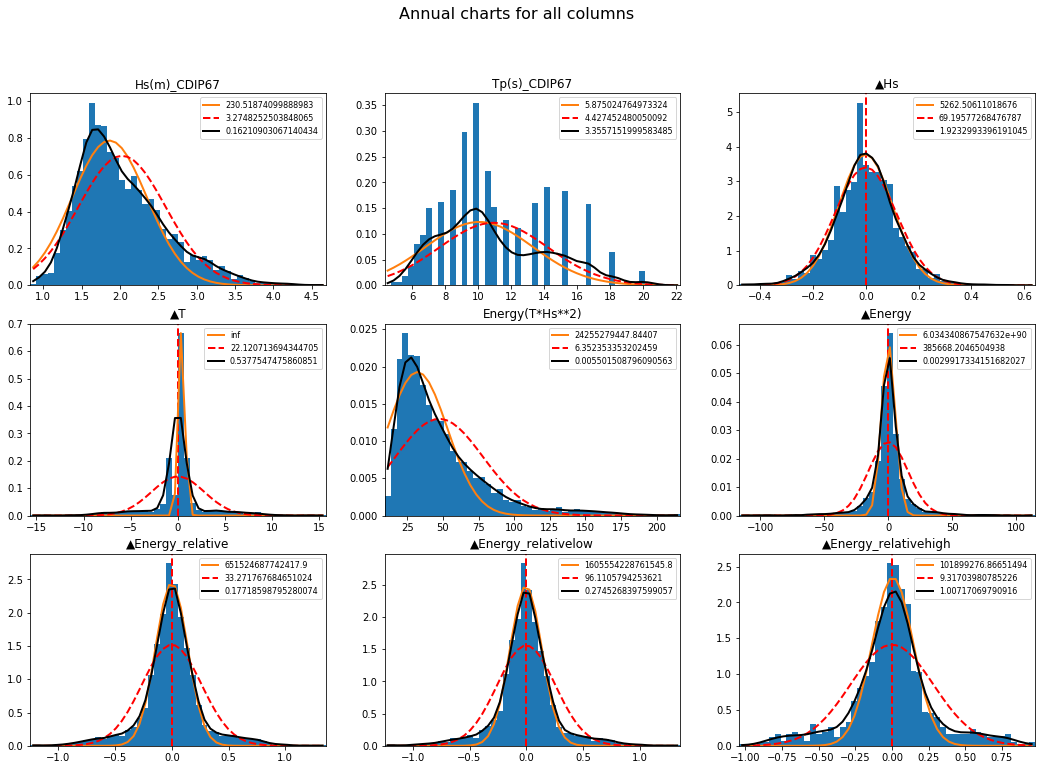

8


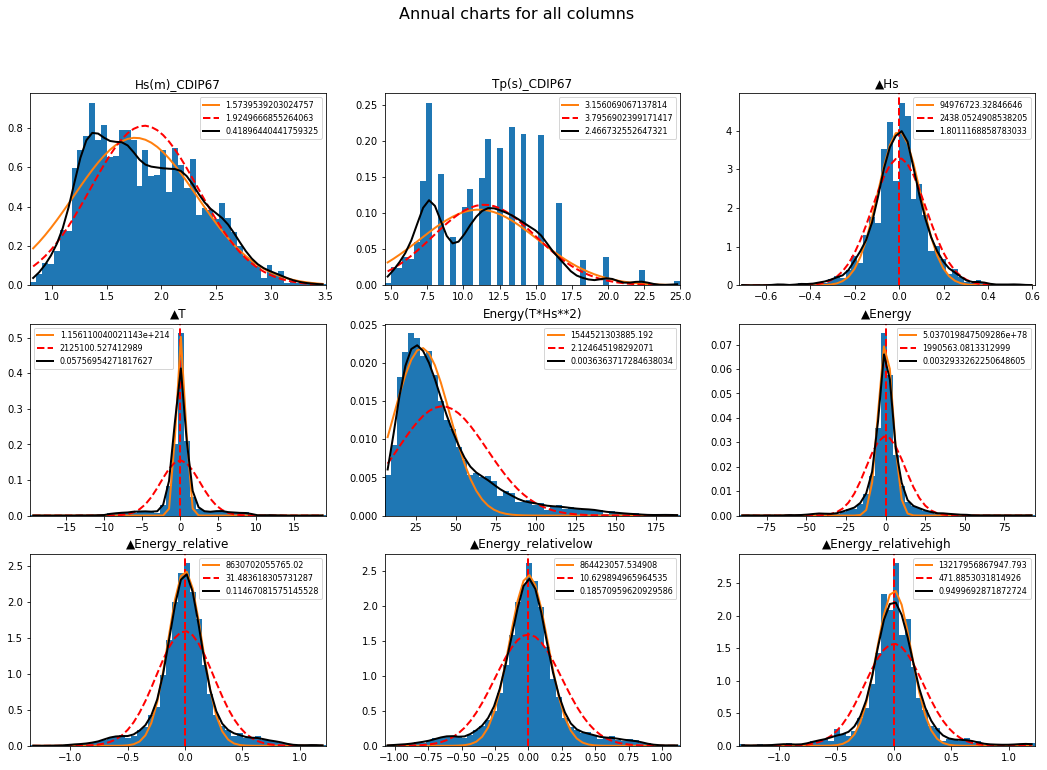

11


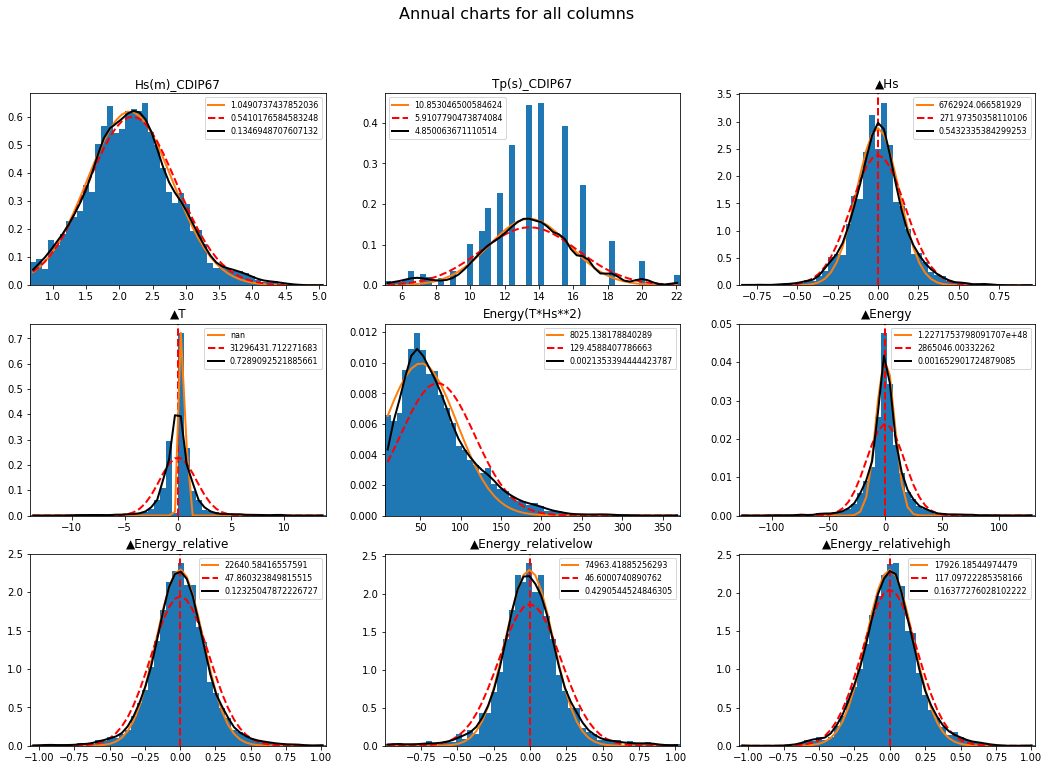

In [195]:
#before tp_to_te
#seasonal histogramming 

df_hist_seasonal(cd)

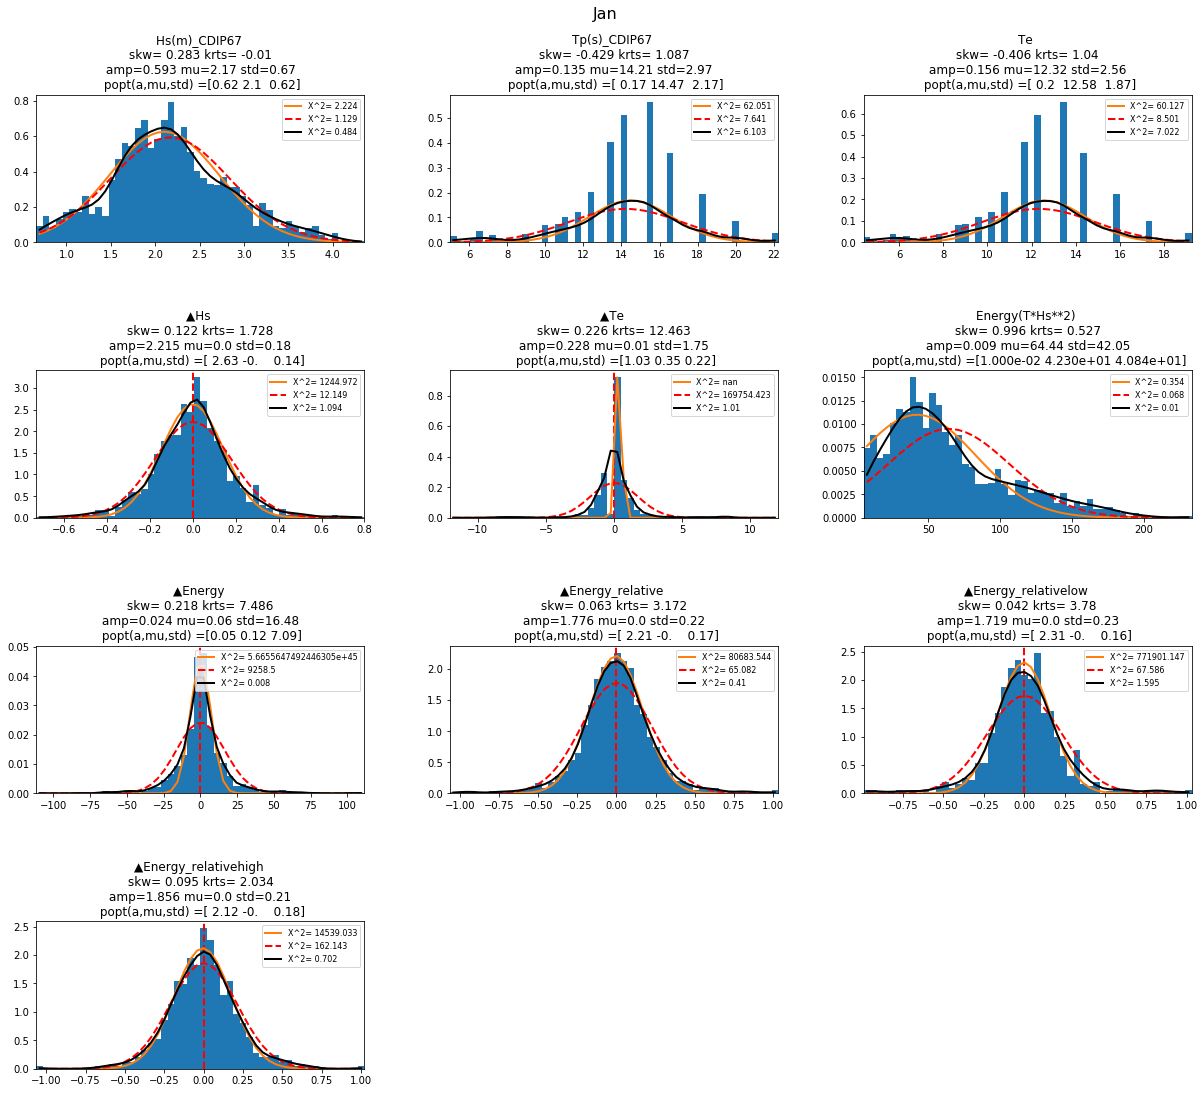

In [17]:
#monthly histogramming after Tp_to_Te
#month January

df_hist_monthly(cd, 1)

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: overflow encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


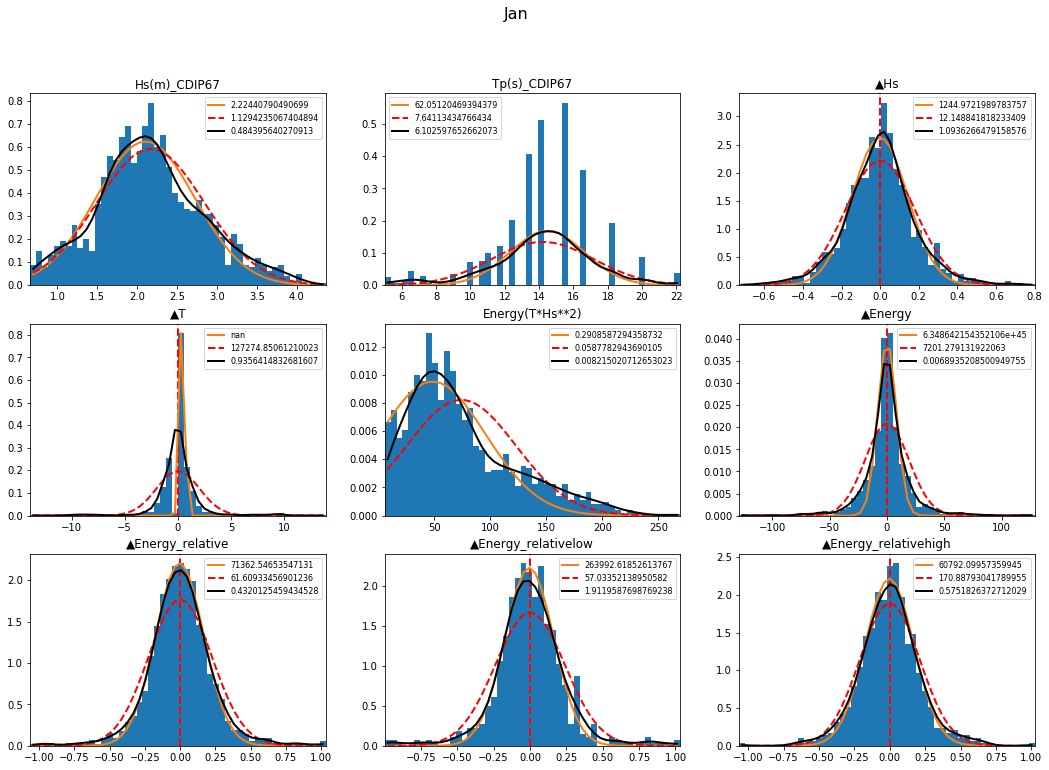

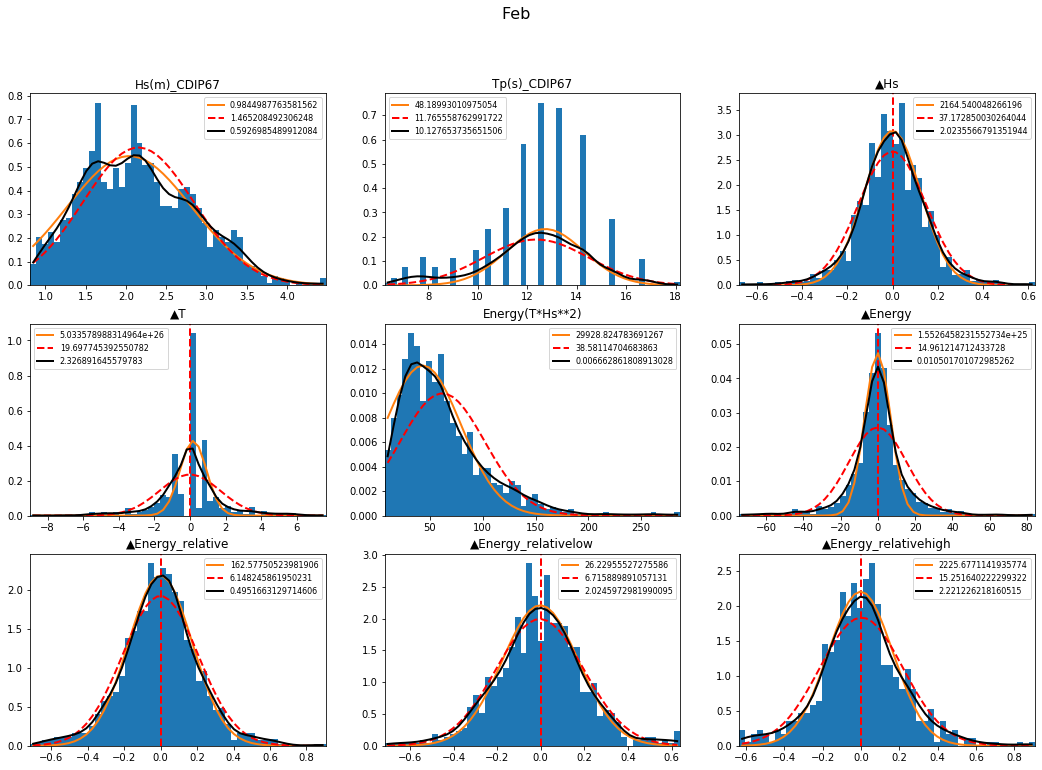

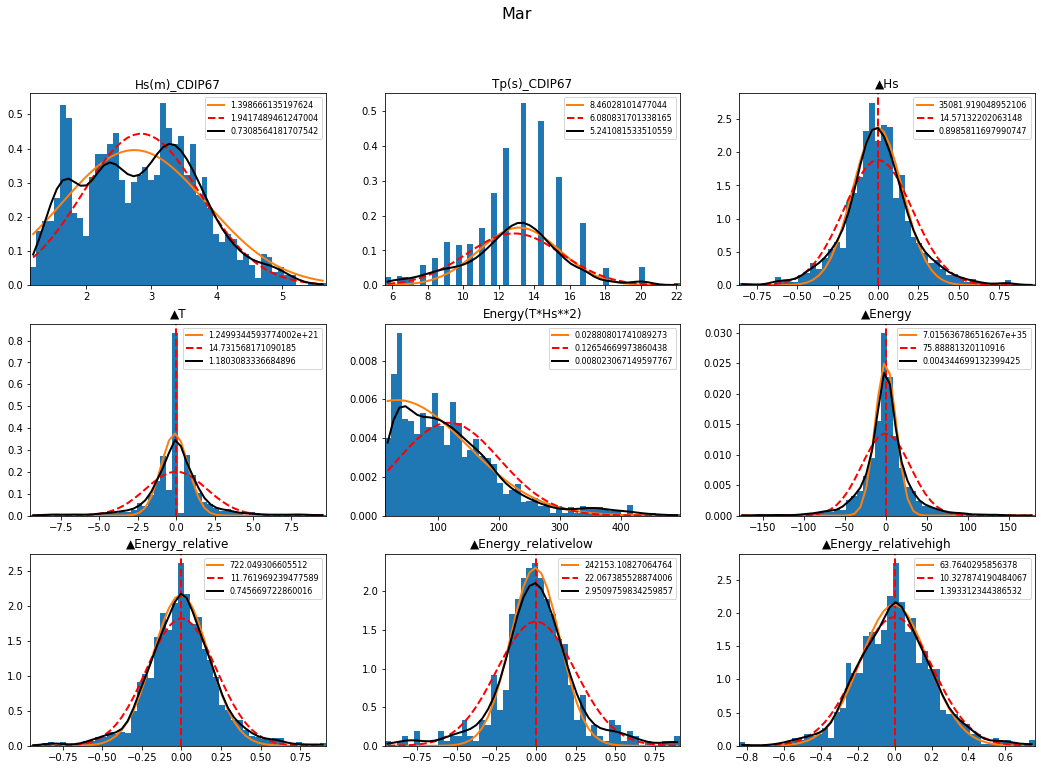

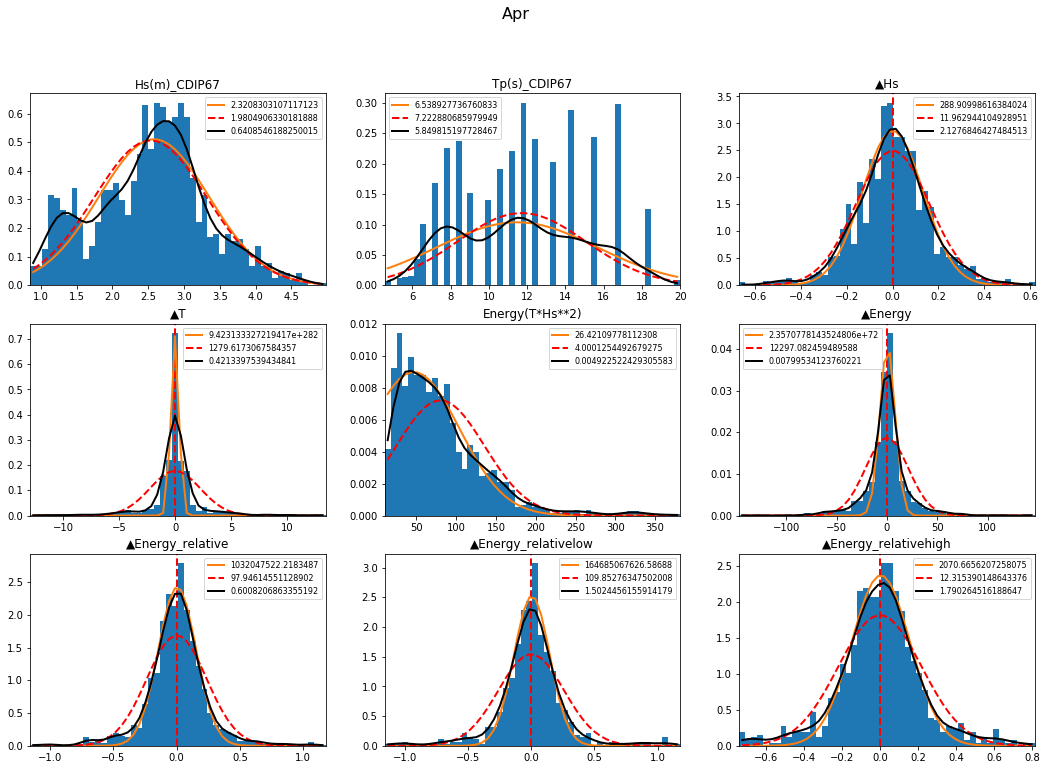

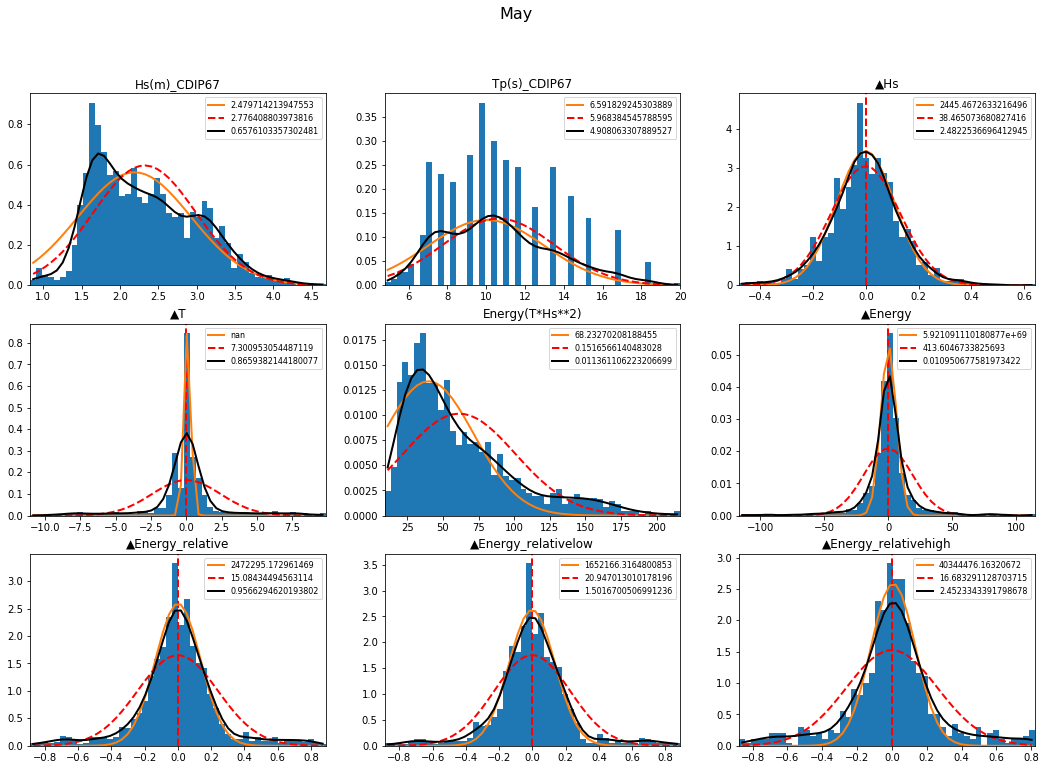

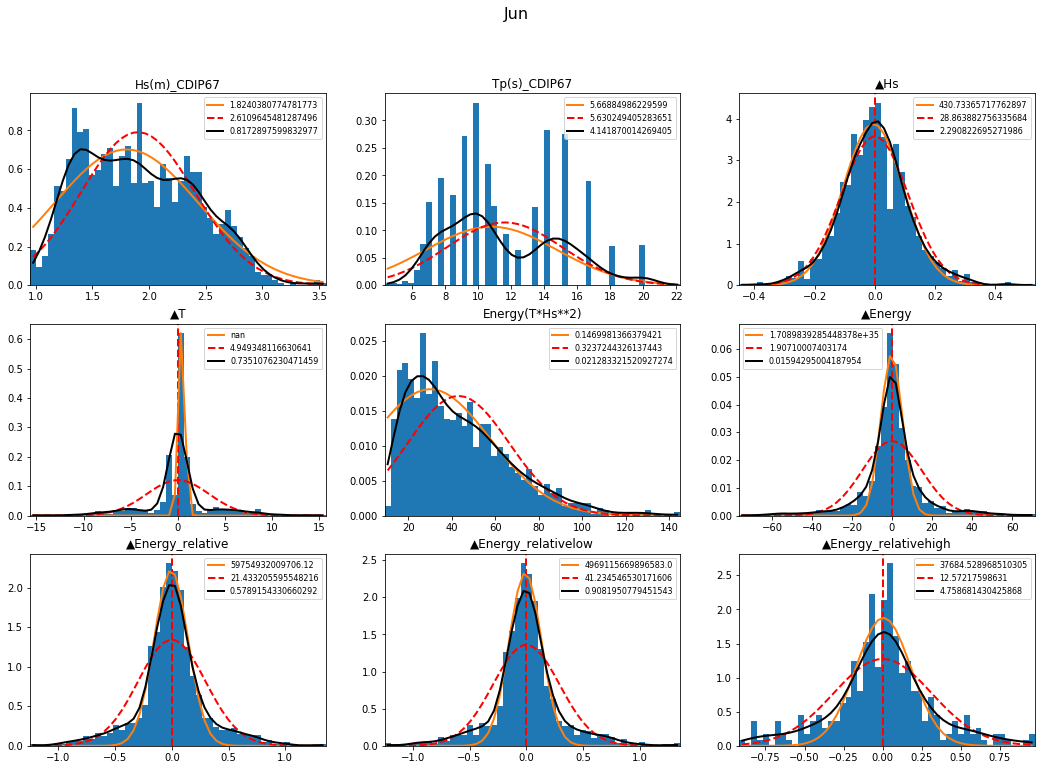

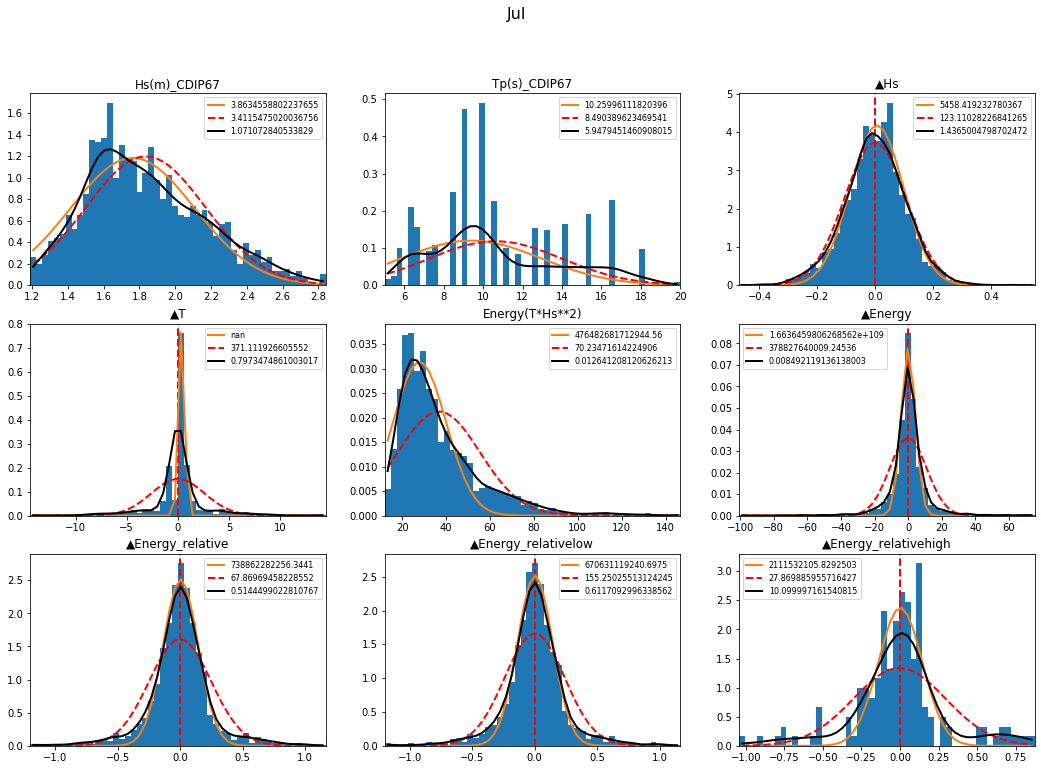

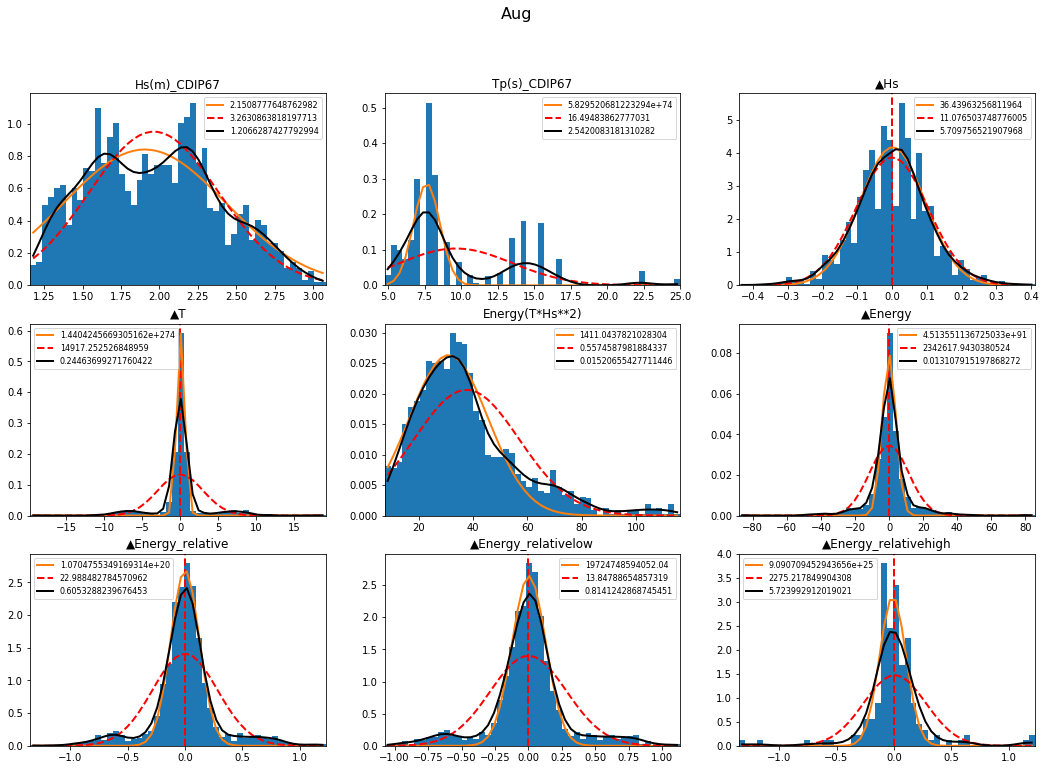

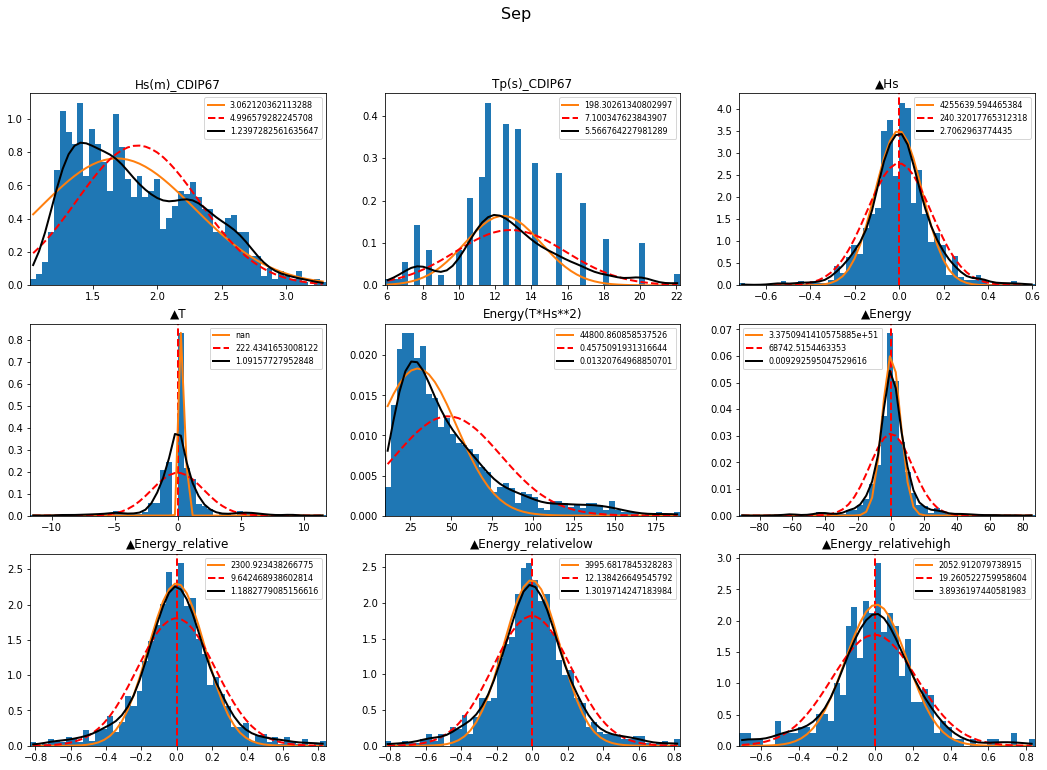

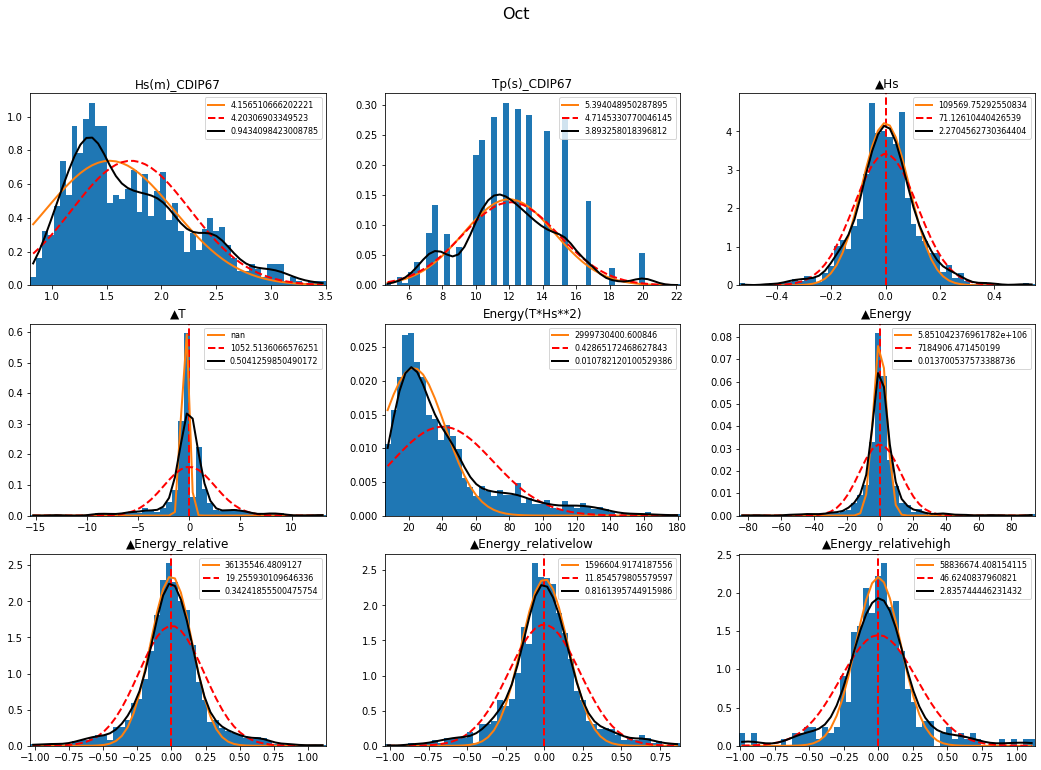

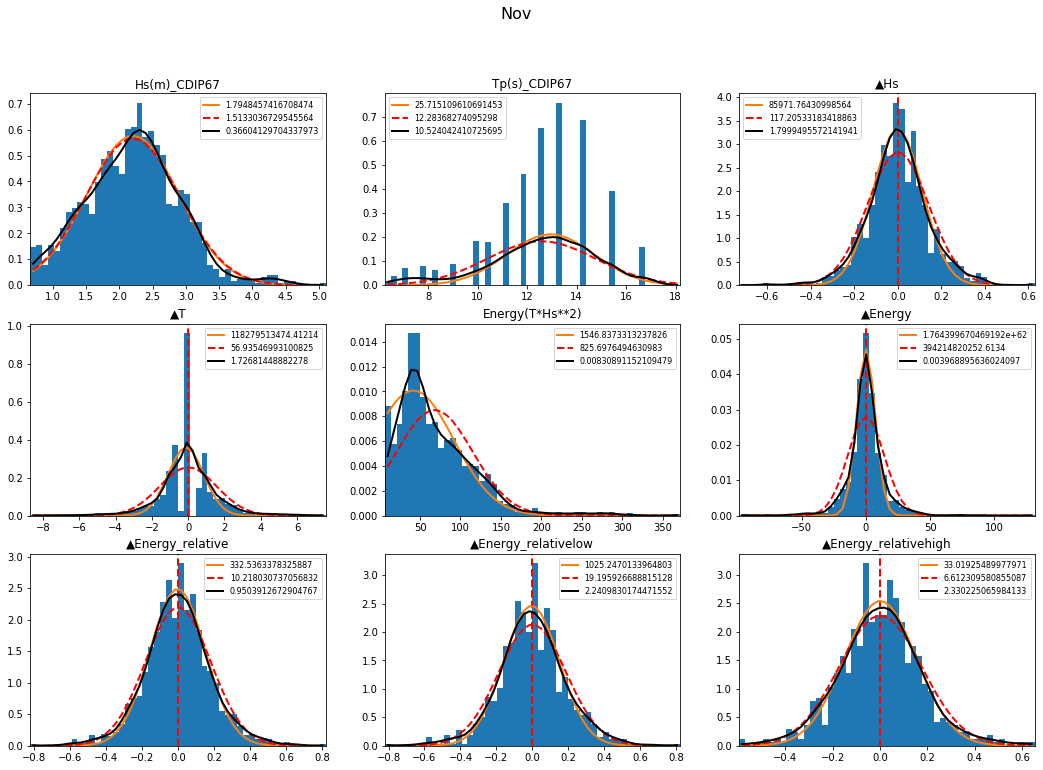

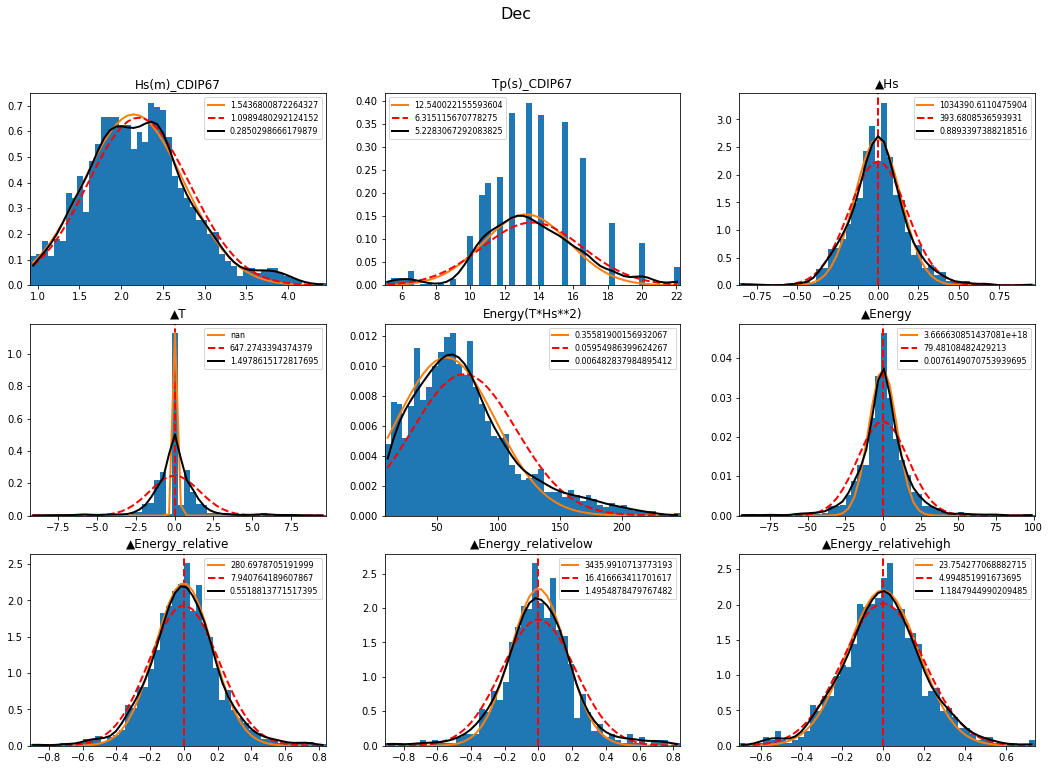

In [20]:
#monthly histogramming before Tp_to_Te

df_hist_monthly(cd)

0.8233258749410651
Power_divergenceResult(statistic=0.8233258749410647, pvalue=1.0)
4.500956014465239
Power_divergenceResult(statistic=4.500956014465239, pvalue=0.9999999999983809)
7.506596884357729
Power_divergenceResult(statistic=7.506596884357776, pvalue=0.9999999915865153)
64670.82781378304
Power_divergenceResult(statistic=64670.827813783006, pvalue=0.0)
0.04443195882481454
Power_divergenceResult(statistic=0.04443195882481453, pvalue=1.0)
3590.5133883464114
Power_divergenceResult(statistic=3590.513388346412, pvalue=0.0)
41.58927834271021
Power_divergenceResult(statistic=41.5892783427102, pvalue=0.3586389670520794)
44.14149777505046
Power_divergenceResult(statistic=44.14149777505045, pvalue=0.263313307127084)
97.35810958206909
Power_divergenceResult(statistic=97.35810958206913, pvalue=6.785880806339975e-07)


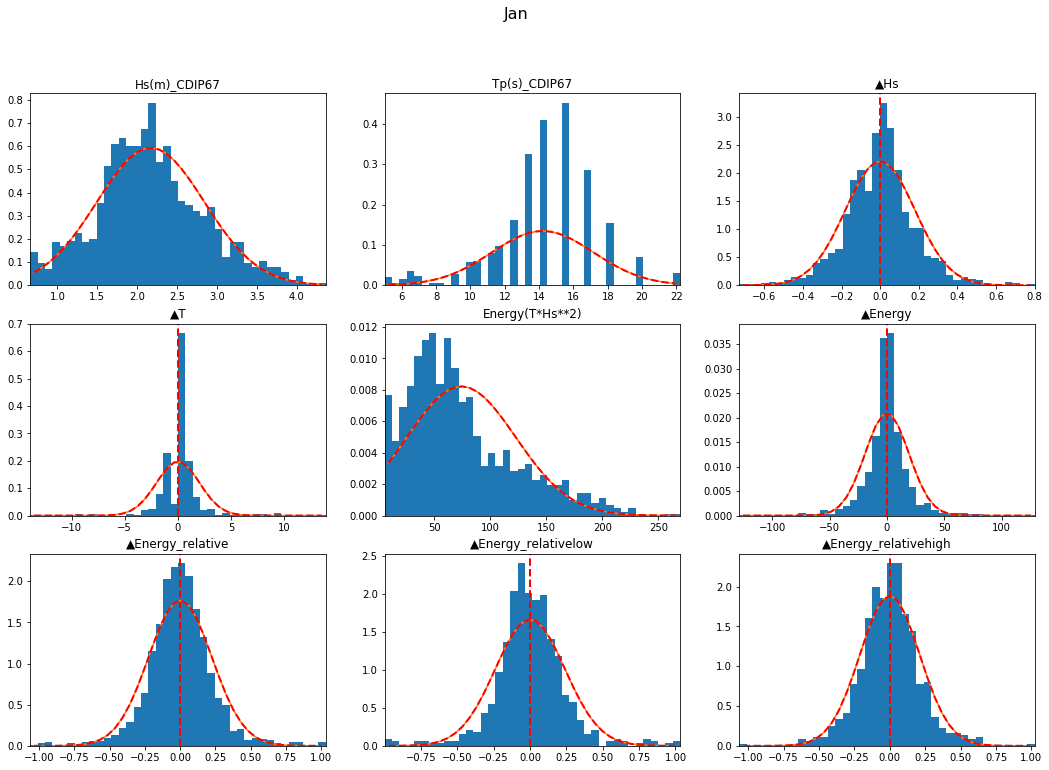

0.9628739206812299
Power_divergenceResult(statistic=0.9628739206812305, pvalue=1.0)
6.835897935792424
Power_divergenceResult(statistic=6.835897935792424, pvalue=0.9999999981397459)
23.44601834792035
Power_divergenceResult(statistic=23.446018347920347, pvalue=0.9768785803897783)
11.29796516302176
Power_divergenceResult(statistic=11.297965163021464, pvalue=0.9999958838362661)
nan
Power_divergenceResult(statistic=22.879211053947426, pvalue=0.9814460956271444)


/home/jupyter-busra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyter-busra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


16.86686869450434
Power_divergenceResult(statistic=16.866868694504337, pvalue=0.9992356783160274)
3.983736869621202
Power_divergenceResult(statistic=3.9837368696212017, pvalue=0.9999999999998087)
4.162341930892998
Power_divergenceResult(statistic=4.162341930892997, pvalue=0.9999999999995864)
9.715133440750034
Power_divergenceResult(statistic=9.715133440750034, pvalue=0.9999995447250469)


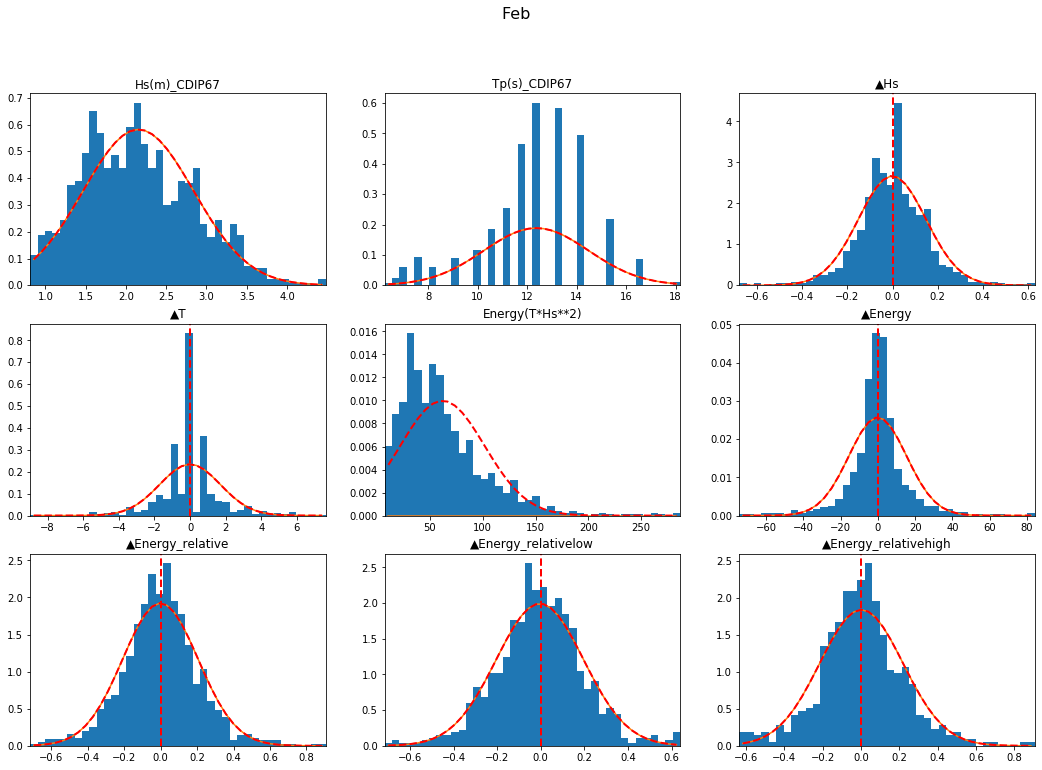

1.3763577221480396
Power_divergenceResult(statistic=1.37635772214804, pvalue=1.0)
3.2684932513459426
Power_divergenceResult(statistic=3.2684932513459426, pvalue=0.9999999999999943)
10.269301959030058
Power_divergenceResult(statistic=10.269301959030058, pvalue=0.9999989643385209)
9.983580268627394
Power_divergenceResult(statistic=9.983580268626927, pvalue=0.9999993169939566)
nan
Power_divergenceResult(statistic=0.08451389365918918, pvalue=1.0)


/opt/tljh/user/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


40.133935975994184
Power_divergenceResult(statistic=40.13393597599418, pvalue=0.4197374790524926)
8.194358171007517
Power_divergenceResult(statistic=8.194358171007517, pvalue=0.9999999663633016)
14.411120860066998
Power_divergenceResult(statistic=14.411120860066998, pvalue=0.9998890631897929)
6.253937388593544
Power_divergenceResult(statistic=6.253937388593543, pvalue=0.9999999995682484)


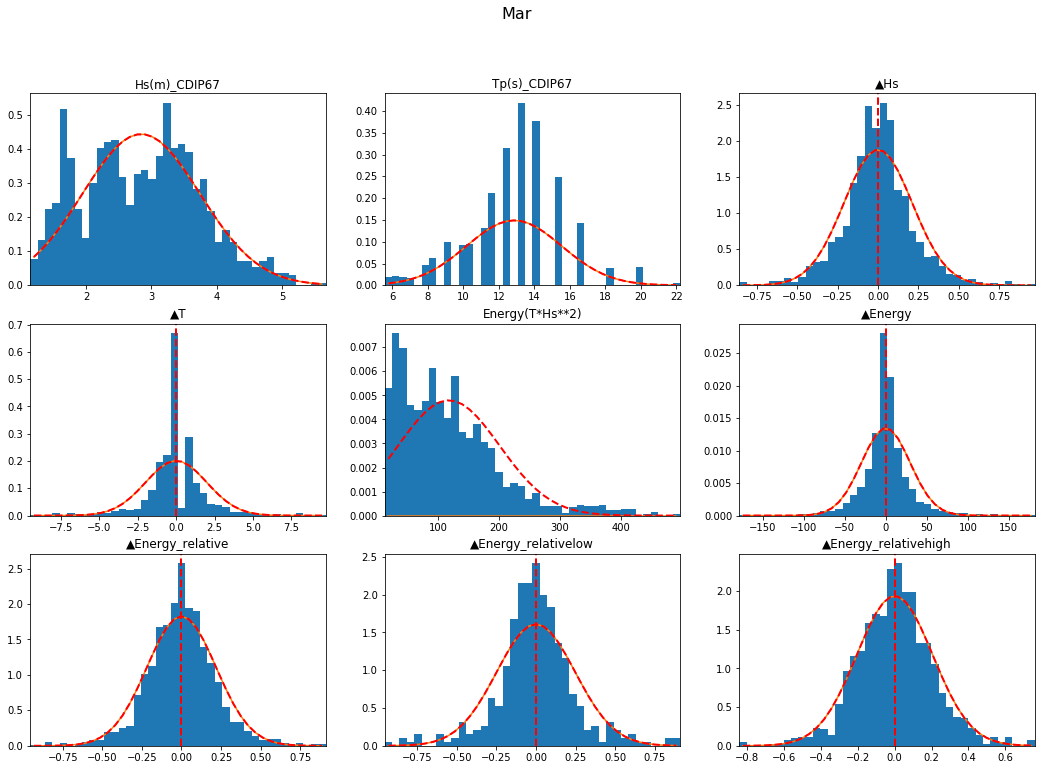

1.4089945811501674
Power_divergenceResult(statistic=1.4089945811501683, pvalue=1.0)
4.118021015059861
Power_divergenceResult(statistic=4.1180210150598615, pvalue=0.9999999999996573)
7.105536709161994
Power_divergenceResult(statistic=7.105536709161993, pvalue=0.9999999965165185)
664.8612324904861
Power_divergenceResult(statistic=664.8612324904307, pvalue=7.2545744182867945e-115)
nan
Power_divergenceResult(statistic=2.7864981703881724, pvalue=0.9999999999999997)
14369.275058571784
Power_divergenceResult(statistic=14369.275058571784, pvalue=0.0)
53.978671155912934
Power_divergenceResult(statistic=53.978671155912934, pvalue=0.05582152822851854)
59.59970131275131
Power_divergenceResult(statistic=59.59970131275131, pvalue=0.01841187991196936)
8.87901680580941
Power_divergenceResult(statistic=8.879016805809382, pvalue=0.9999998834228203)


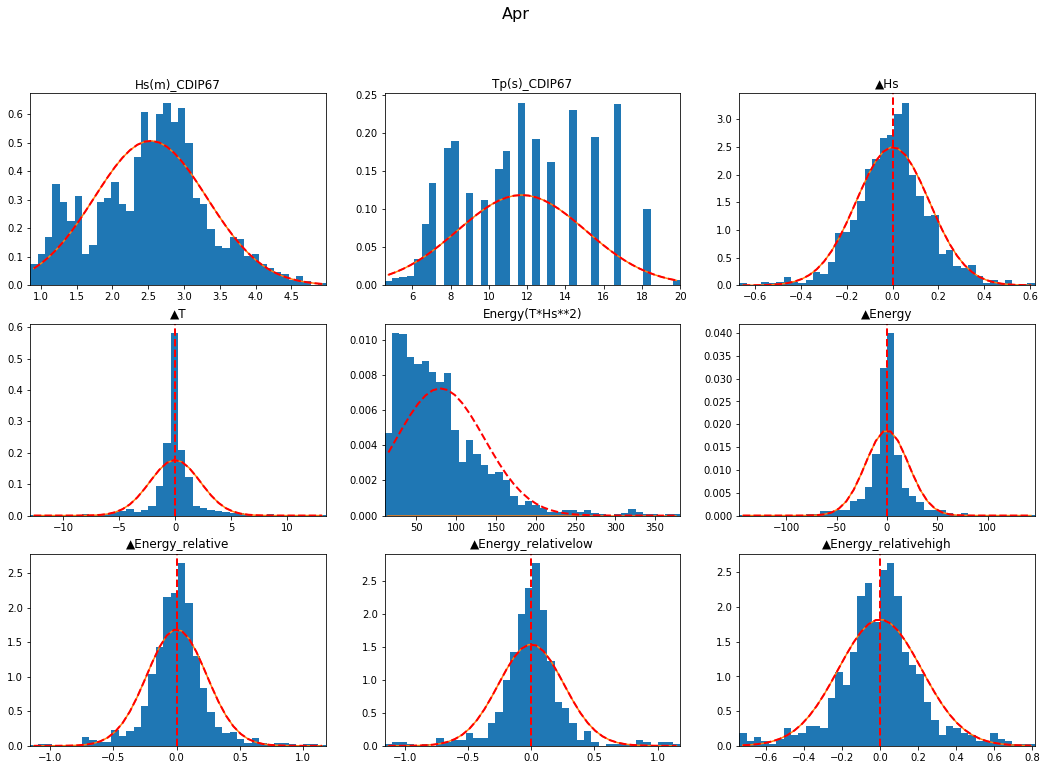

2.278672627362361
Power_divergenceResult(statistic=2.2786726273623614, pvalue=1.0)
3.224034545098393
Power_divergenceResult(statistic=3.2240345450983936, pvalue=0.9999999999999956)
21.805677081625696
Power_divergenceResult(statistic=21.805677081625696, pvalue=0.988155047274425)
4.939142564731338
Power_divergenceResult(statistic=4.939142564731629, pvalue=0.9999999999919447)
nan
Power_divergenceResult(statistic=0.11087238657703698, pvalue=1.0)
291.12359657131947
Power_divergenceResult(statistic=291.1235965713195, pvalue=2.6024006810504312e-40)
11.667143970138238
Power_divergenceResult(statistic=11.667143970138245, pvalue=0.9999935163268934)
16.291905738842267
Power_divergenceResult(statistic=16.291905738842285, pvalue=0.9994929579012126)
12.368317381677162
Power_divergenceResult(statistic=12.36831738167773, pvalue=0.9999854180340048)


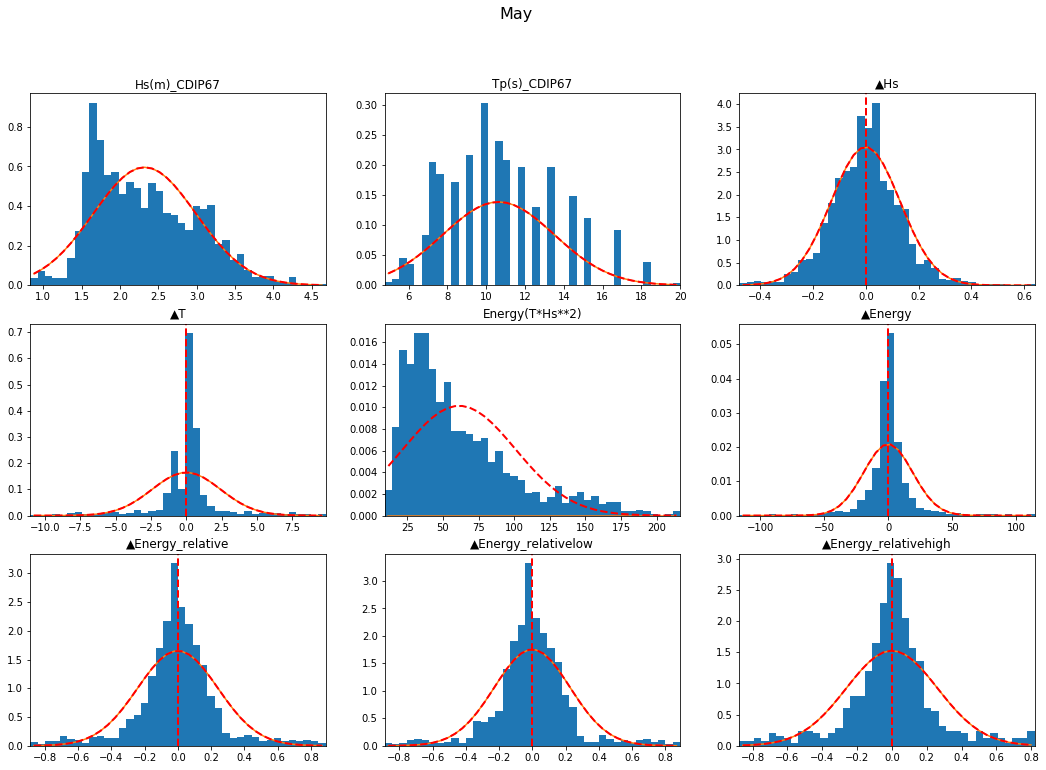

1.9463211888394532
Power_divergenceResult(statistic=1.9463211888394534, pvalue=1.0)
3.3016426482183165
Power_divergenceResult(statistic=3.3016426482183165, pvalue=0.9999999999999932)
19.095172771004318
Power_divergenceResult(statistic=19.095172771004318, pvalue=0.9969229136460802)
5.049717065879731
Power_divergenceResult(statistic=5.049717065879758, pvalue=0.999999999988227)
nan
Power_divergenceResult(statistic=0.2064270654935711, pvalue=1.0)
1.1947190028340682
Power_divergenceResult(statistic=1.194719002834068, pvalue=1.0)
13.22942869101258
Power_divergenceResult(statistic=13.229428691012577, pvalue=0.9999637439732051)
24.369677795888663
Power_divergenceResult(statistic=24.36967779588867, pvalue=0.9676592692180392)
7.733434029001568
Power_divergenceResult(statistic=7.733434029001566, pvalue=0.9999999864880074)


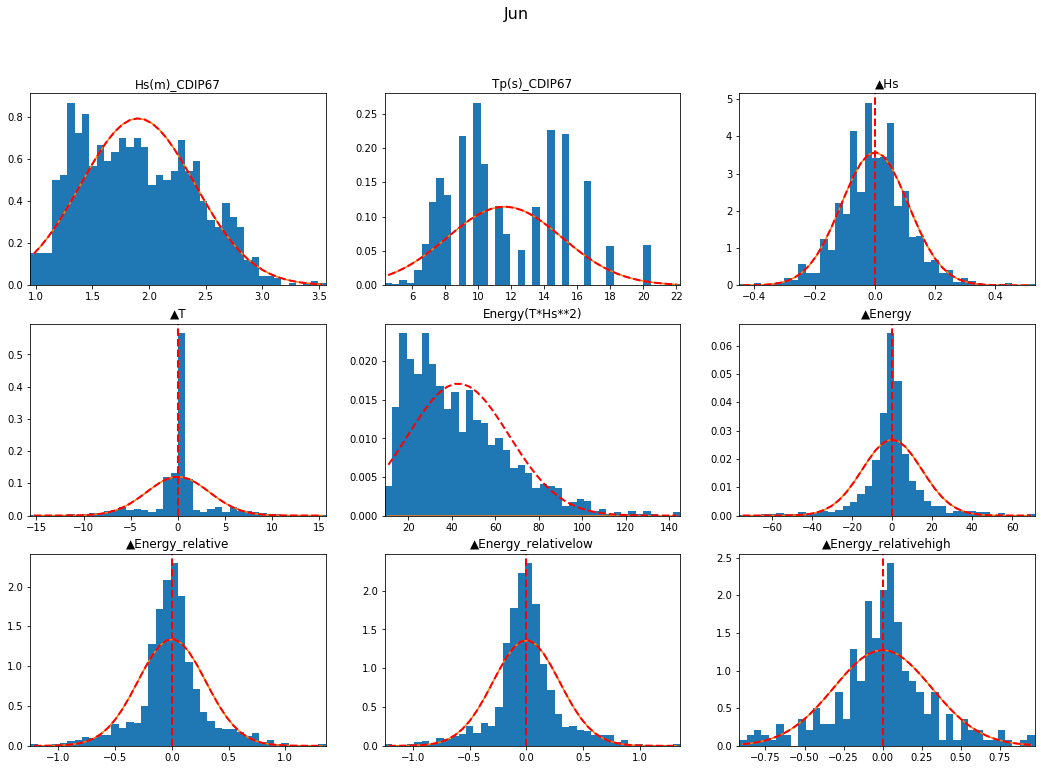

2.5756751595003804
Power_divergenceResult(statistic=2.5756751595003795, pvalue=0.9999999999999999)
5.219095378298467
Power_divergenceResult(statistic=5.219095378298466, pvalue=0.999999999979321)
69.13944857369538
Power_divergenceResult(statistic=69.13944857369479, pvalue=0.0020774869434448096)
275.7217099439404
Power_divergenceResult(statistic=275.72170994394185, pvalue=2.1213601566763427e-37)
nan
Power_divergenceResult(statistic=40.83919918754736, pvalue=0.389605561775792)
169480366812.53952
Power_divergenceResult(statistic=169480366812.5395, pvalue=0.0)
40.959081046001394
Power_divergenceResult(statistic=40.9590810460014, pvalue=0.38457771351145187)
90.2581090494446
Power_divergenceResult(statistic=90.25810904944458, pvalue=6.086189909034246e-06)
21.50794779333323
Power_divergenceResult(statistic=21.50794779333323, pvalue=0.9896232820511762)


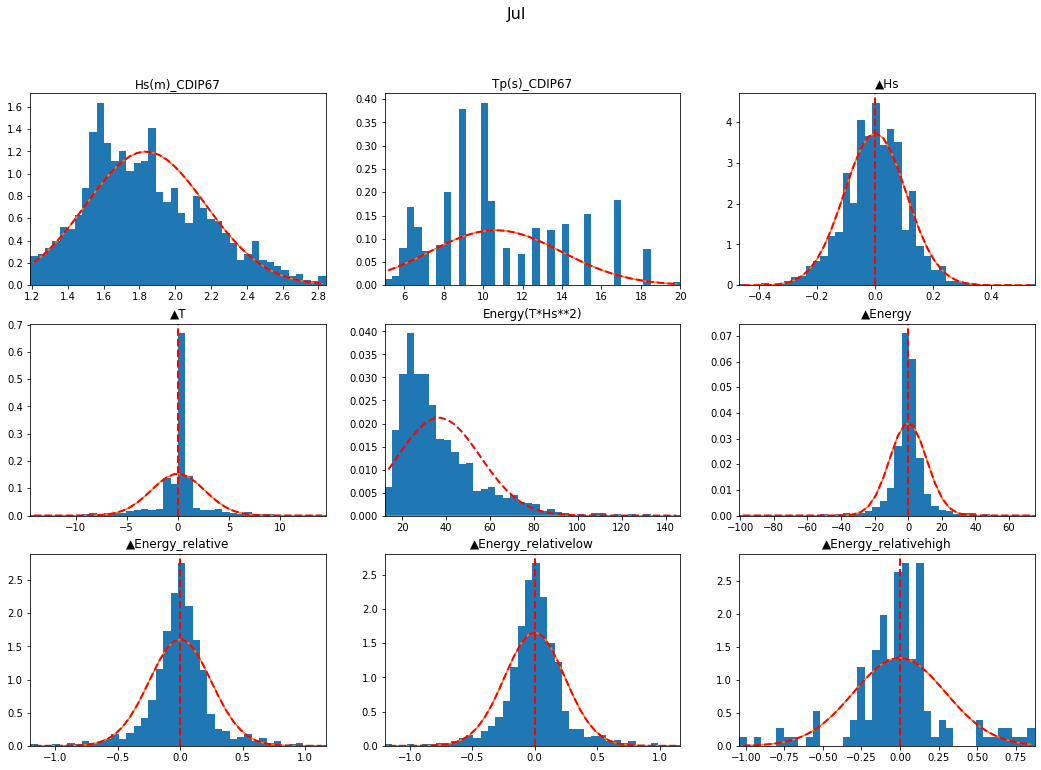

2.2717753842210415
Power_divergenceResult(statistic=2.271775384221041, pvalue=1.0)
9.622626108923647
Power_divergenceResult(statistic=9.622626108923647, pvalue=0.9999996054542133)
4.763721833876663
Power_divergenceResult(statistic=4.763721833876663, pvalue=0.9999999999956765)
7640.54437151355
Power_divergenceResult(statistic=7640.544371512738, pvalue=0.0)
inf
Power_divergenceResult(statistic=0.3198666669168557, pvalue=1.0)
1067976.6386046915
Power_divergenceResult(statistic=1067976.6386046915, pvalue=0.0)
15.318756223225058
Power_divergenceResult(statistic=15.318756223225058, pvalue=0.9997605124504765)
10.402720431419588
Power_divergenceResult(statistic=10.402720431419574, pvalue=0.9999987486417196)
1327.6455693218197
Power_divergenceResult(statistic=1327.64556932182, pvalue=3.0393974745768786e-253)


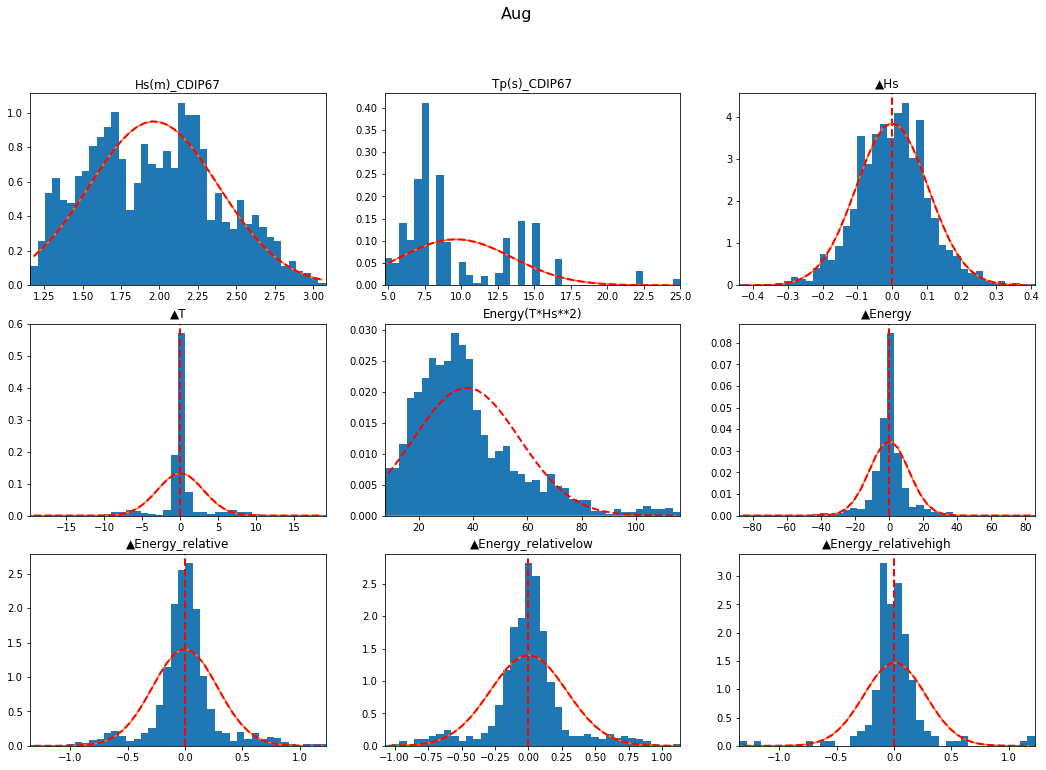

3.5548261914140893
Power_divergenceResult(statistic=3.55482619141409, pvalue=0.9999999999999746)
3.99324670122016
Power_divergenceResult(statistic=3.9932467012201593, pvalue=0.9999999999998005)
144.16692979407983
Power_divergenceResult(statistic=144.16692979407995, pvalue=5.594893189989344e-14)
122.05592892960405
Power_divergenceResult(statistic=122.05592892960405, pvalue=1.7298788746669175e-10)
nan
Power_divergenceResult(statistic=0.32379570910632005, pvalue=1.0)
34625.157158352624
Power_divergenceResult(statistic=34625.15715835227, pvalue=0.0)
7.409718547184083
Power_divergenceResult(statistic=7.409718547184083, pvalue=0.9999999931643292)
7.520562114470017
Power_divergenceResult(statistic=7.5205621144700165, pvalue=0.9999999913331605)
12.35978104656211
Power_divergenceResult(statistic=12.359781046562109, pvalue=0.9999855555904613)


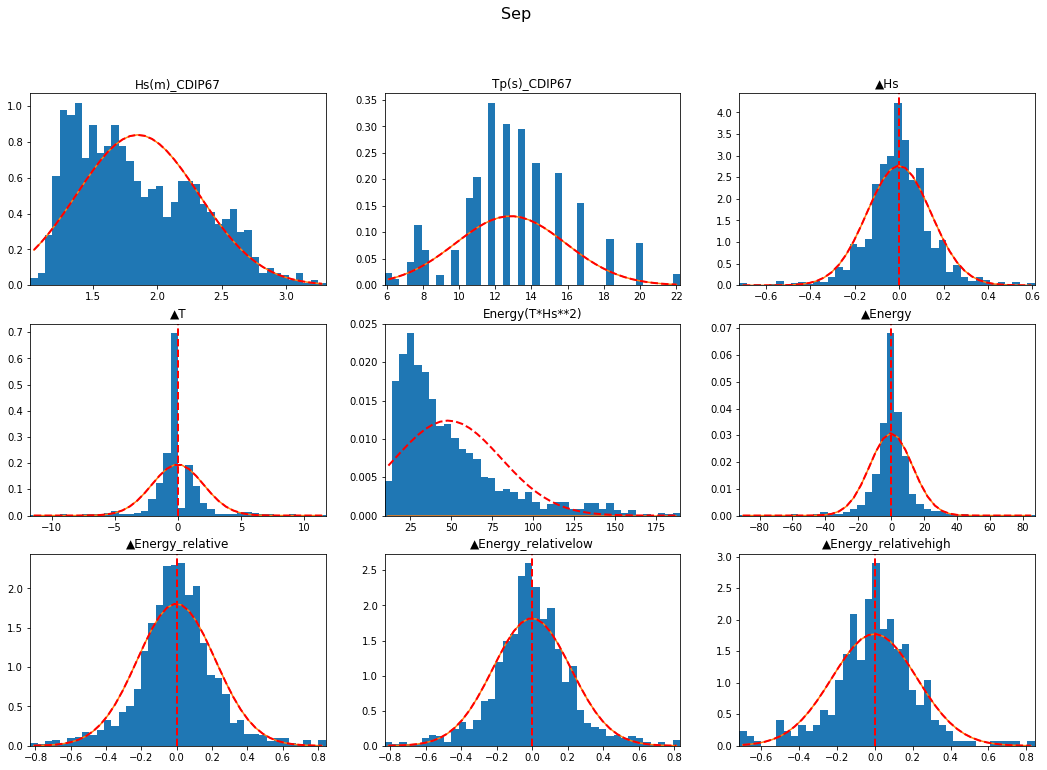

3.0273190406441643
Power_divergenceResult(statistic=3.0273190406441643, pvalue=0.9999999999999986)
2.490040003371885
Power_divergenceResult(statistic=2.4900400033718837, pvalue=1.0)
39.50254154799913
Power_divergenceResult(statistic=39.50254154799913, pvalue=0.4474309194561949)
580.5782999755596
Power_divergenceResult(statistic=580.5782999755595, pvalue=1.1940532724202484e-97)
0.3055487007854054
Power_divergenceResult(statistic=0.3055487007854054, pvalue=1.0)
3526821.682672796
Power_divergenceResult(statistic=3526821.682672683, pvalue=0.0)
11.95662418815762
Power_divergenceResult(statistic=11.95662418815764, pvalue=0.9999908667244077)
8.00863871288839
Power_divergenceResult(statistic=8.008638712888391, pvalue=0.9999999765248457)
27.040969236871568
Power_divergenceResult(statistic=27.040969236871568, pvalue=0.9259769998813688)


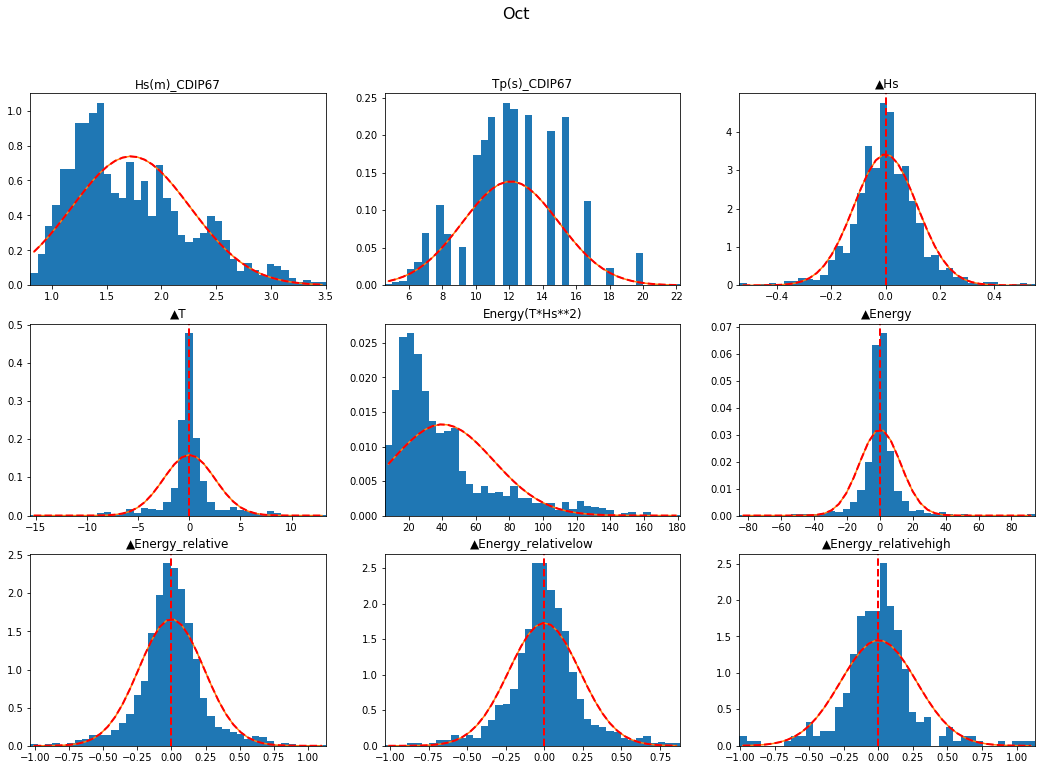

1.0192552767807919
Power_divergenceResult(statistic=1.0192552767807916, pvalue=1.0)
7.090324004985561
Power_divergenceResult(statistic=7.090324004985561, pvalue=0.9999999966350731)
68.34857477470273
Power_divergenceResult(statistic=68.34857477470273, pvalue=0.0025210882646638055)
32.68488265008406
Power_divergenceResult(statistic=32.68488265008959, pvalue=0.7520996386613691)
465.95399185612825
Power_divergenceResult(statistic=465.9539918561283, pvalue=1.612746121648888e-74)
175632136971.06232
Power_divergenceResult(statistic=175632136971.05118, pvalue=0.0)
6.062530052972738
Power_divergenceResult(statistic=6.06253005297275, pvalue=0.9999999997422416)
11.148172554958329
Power_divergenceResult(statistic=11.148172554958233, pvalue=0.9999965967333637)
5.0113547999816355
Power_divergenceResult(statistic=5.011354799981635, pvalue=0.9999999999896682)


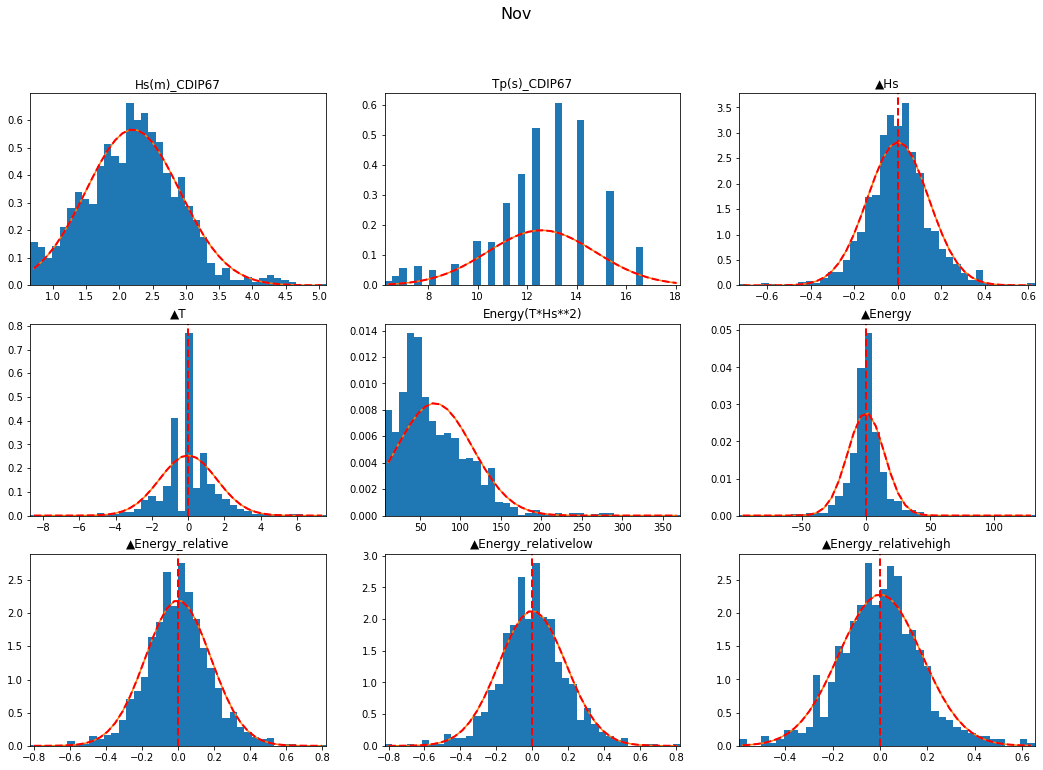

0.8855406165111888
Power_divergenceResult(statistic=0.885540616511189, pvalue=1.0)
3.6324529476693046
Power_divergenceResult(statistic=3.632452947669306, pvalue=0.9999999999999627)
603.4952025973931
Power_divergenceResult(statistic=603.495202597393, pvalue=2.5740078406507033e-102)
383.0944367331259
Power_divergenceResult(statistic=383.0944367331248, pvalue=4.3170658688744784e-58)
nan
Power_divergenceResult(statistic=0.04572828368340093, pvalue=1.0)
124.999307576072
Power_divergenceResult(statistic=124.99930757607201, pvalue=6.111629681717383e-11)
8.354597621435987
Power_divergenceResult(statistic=8.354597621435989, pvalue=0.9999999544914658)
17.731276960275974
Power_divergenceResult(statistic=17.73127696027604, pvalue=0.9986409965382853)
3.374041201661573
Power_divergenceResult(statistic=3.3740412016615733, pvalue=0.99999999999999)


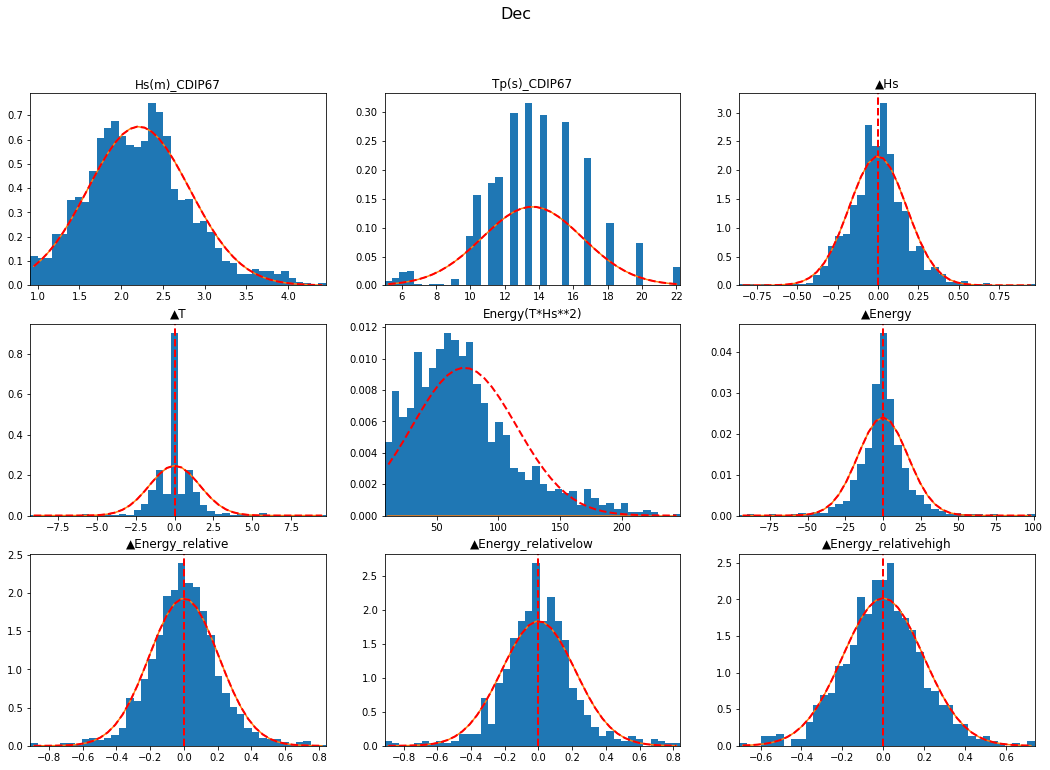

In [51]:
df_hist_monthly(cd)

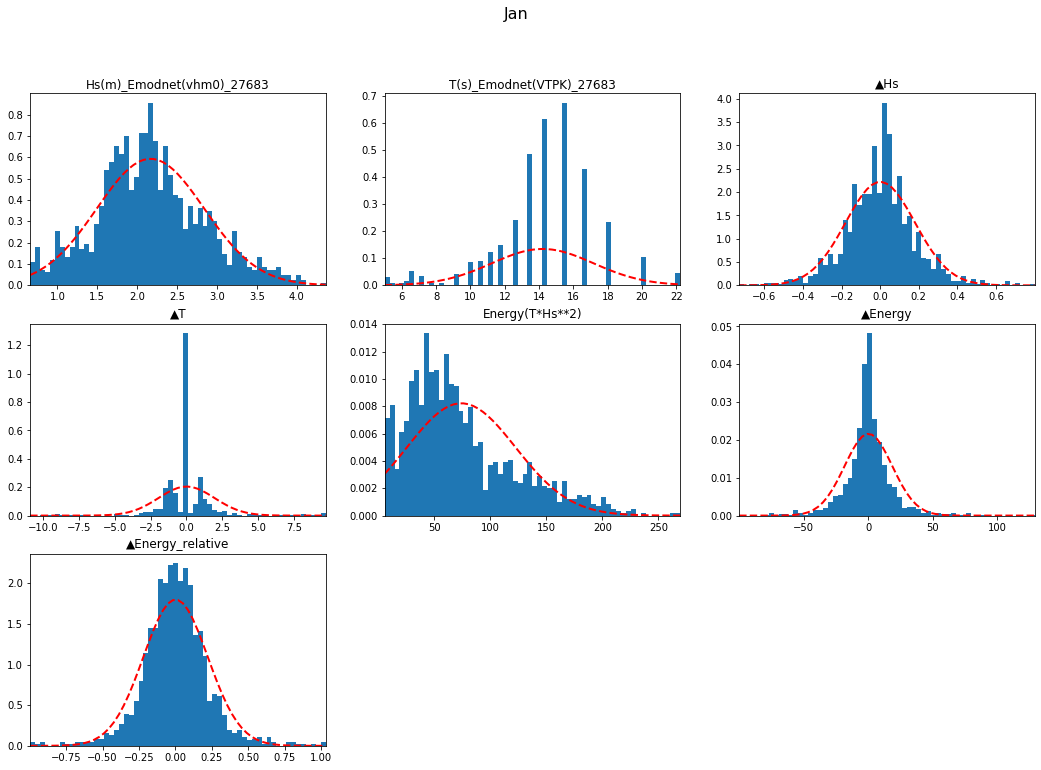

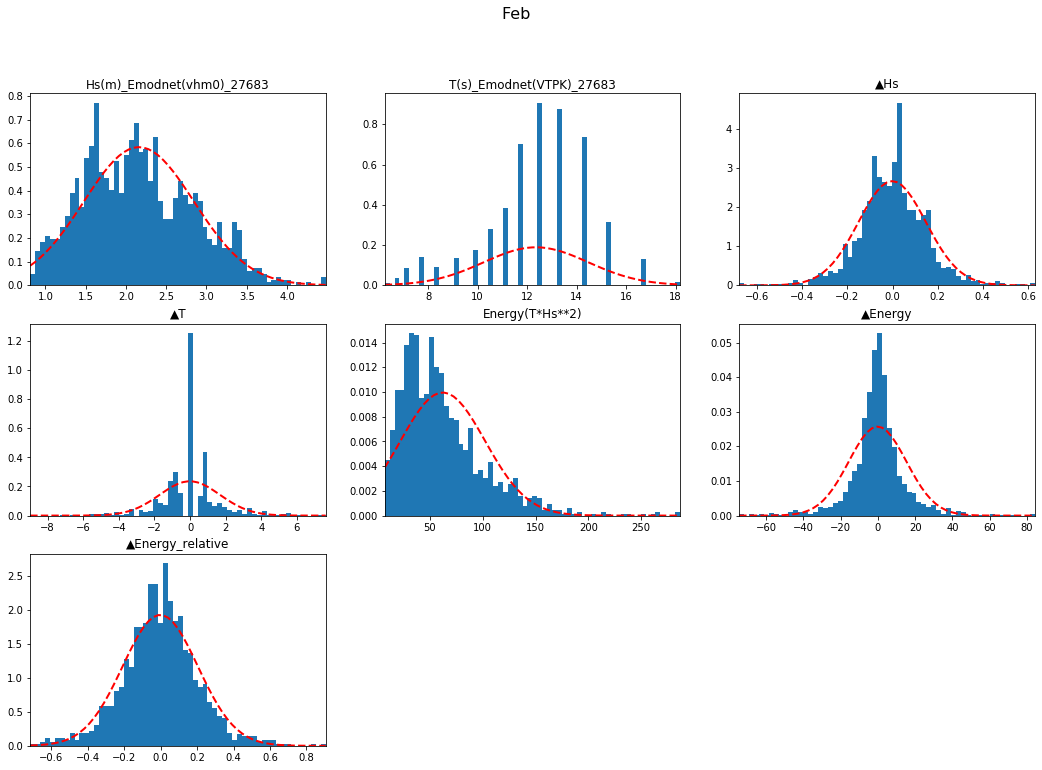

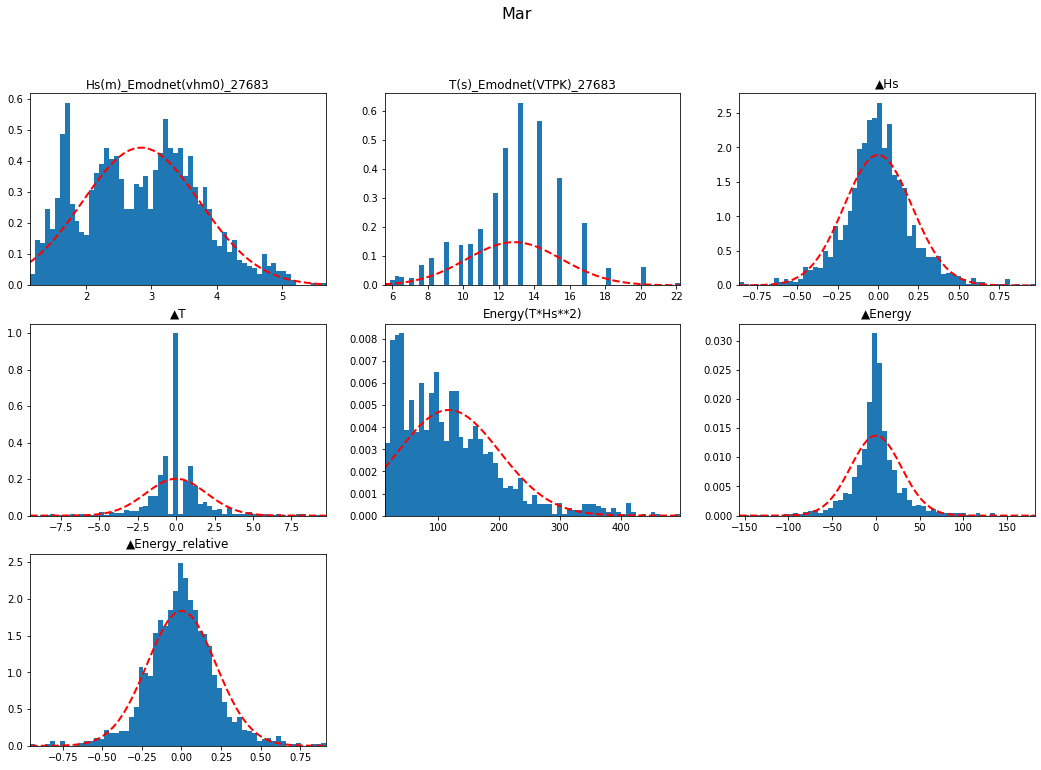

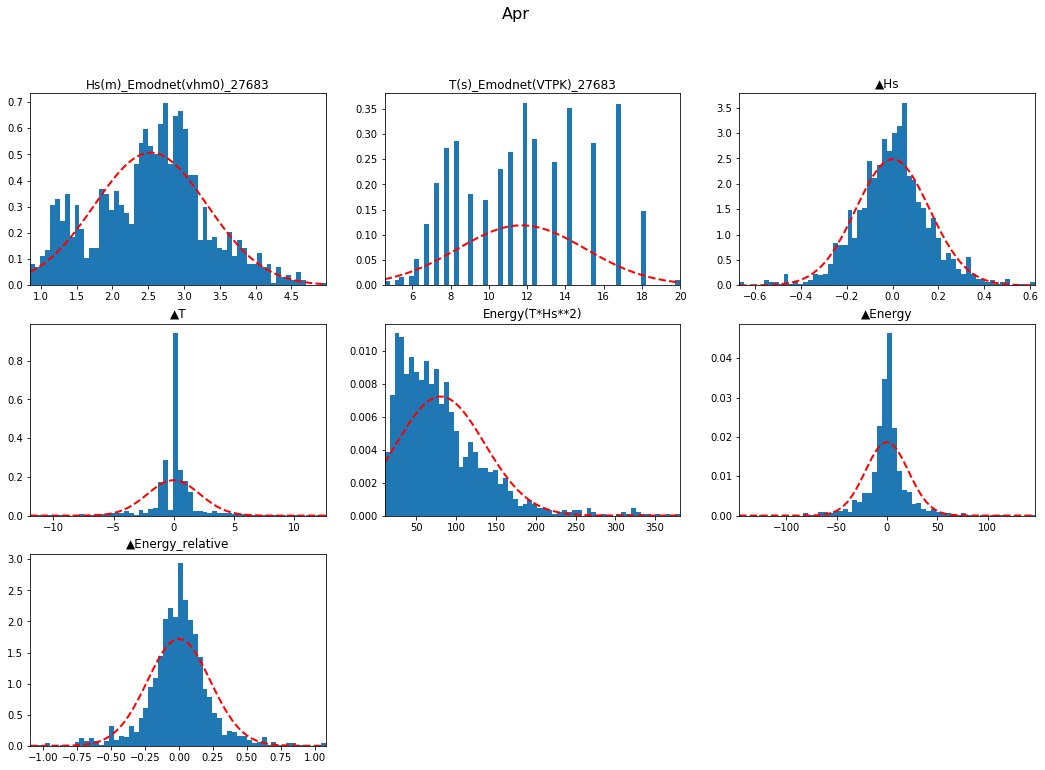

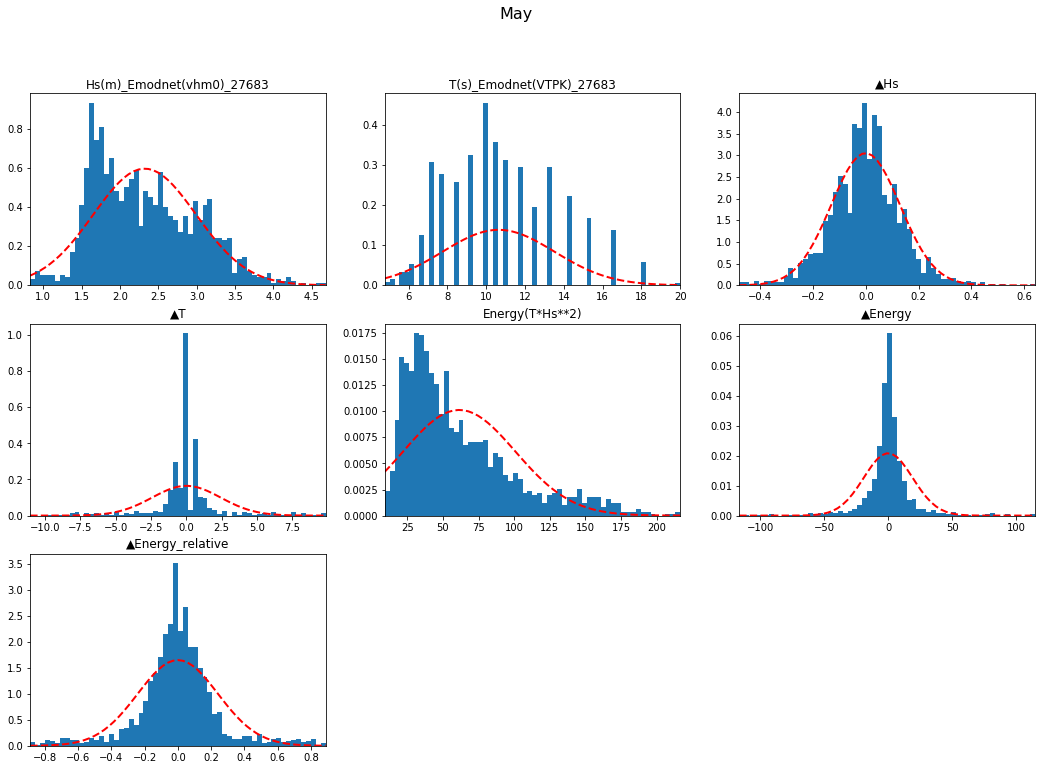

In [ ]:
df_hist_monthly(emd)

In [99]:
#plot for the first three columns. Hs, Tp, Te

def df_Rayleigh_histFit(df, monthly=False): 
    #number of charts
    #k = len(df.columns)
    k = 3
    #number of chart columns for representing
    fig_cols = 3
    #number of chart rows for representing
    m = (k - 1) // fig_cols + 1
    
    fig = plt.figure(figsize=(fig_cols * 6, m * 4))   #dpi=300
    
    df_new = df.copy(deep=True)
    df_new.drop(df_new.columns[3:], axis=1 , inplace=True)
    
    for i, (name, col) in enumerate(df_new.iteritems()):       
        col=col.dropna()
        col = col.astype(float)
        ax = fig.add_subplot(m, fig_cols, i+1)
        if not (col.empty):
            # Fit to normal distribution
            (mu, sigma) = stats.norm.fit(col)
            #col = (col-mu) / sigma 
            #mu2,sigma2= stats.rayleigh.fit(col)
            ####
            ##
            median = col.median()
    
            ax.set_xlim(col.min(),col.max())
        
            # the histogram of the data
            n, bins, patches = ax.hist(col, bins=50, density=True)      #density/normed same..
            #ax.axvline(x=0, color='r', linestyle='dashed', linewidth=2)       
                        
            bin_width = bins[1]-bins[0]
            bins_middle = ((bins[1:]+bins[:-1])/2)
            bin_count = len(bins)-1
            
            #(popt, pcov) = optimize.curve_fit(Weibull, bins_middle, n) #, p0=[sigma], bounds=(0,np.inf)
            (popt, pcov) = optimize.curve_fit(Rayleigh, bins_middle, n) #, p0=[sigma], bounds=(0,np.inf)

            ray = Rayleigh(bins_middle, *popt)            
            plt.plot(bins_middle, ray, lw=2, label='X^2= ' + str(round(stats.chisquare(n,ray,49-len(popt))[0],3)))

            ax.set_title(name + ' \n mu=' + str(round(mu,2)) + ' std=' + str(round(sigma,2))
                         + ' \n popt(std) =' + str(popt.round(2)))
            
            plt.legend(prop={'size': 8})

    #if len(df.groupby(df.index.month)) == 1:
    if(monthly == True):
        fig.suptitle(str(calendar.month_abbr[(df.index.month)[0]]), fontsize=16)
    else:
        fig.suptitle('Annual charts for all columns', fontsize=16)
    #plt.show()
    fig.tight_layout(pad=5.0)
    return

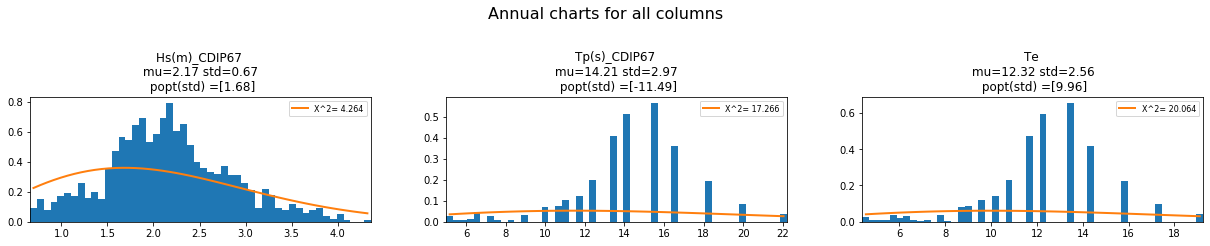

In [105]:
#weibull
df_Rayleigh_histFit(cd.loc['2011-01'])

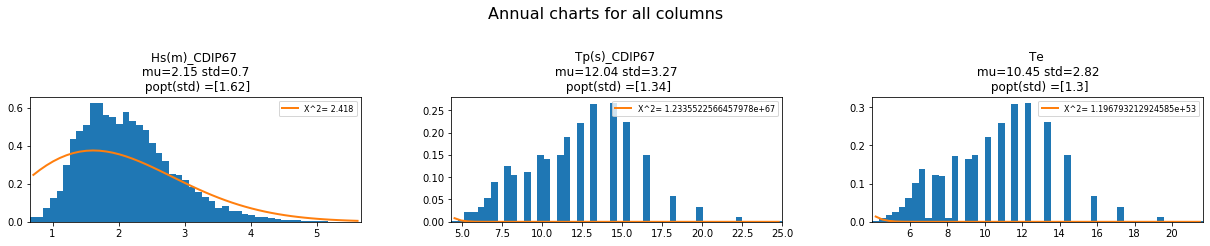

In [100]:
#with rayleigh.fit params
df_Rayleigh_histFit(cd)

2.1468013209883825 0.701859076212575 0.6589340631439944 1.1632474815104612
12.042261013150911 3.2721207370199723 4.34869675913537 5.911780523409716
10.448547094116707 2.8170998820665893 4.000737552722963 4.975500225016543


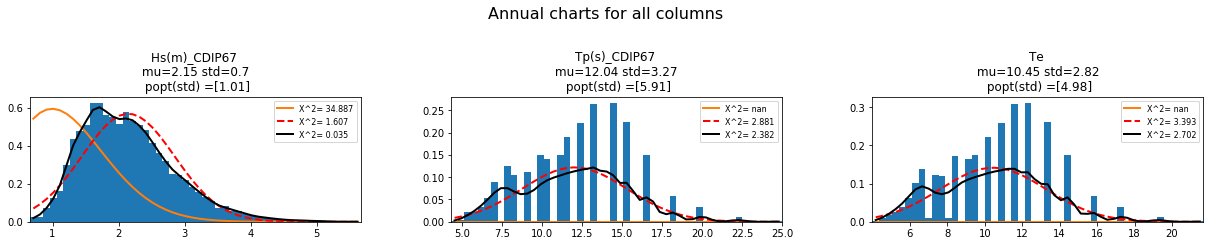

In [47]:
#with rayleigh.fit params
df_Rayleigh_histFit(cd)

# NDBC

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


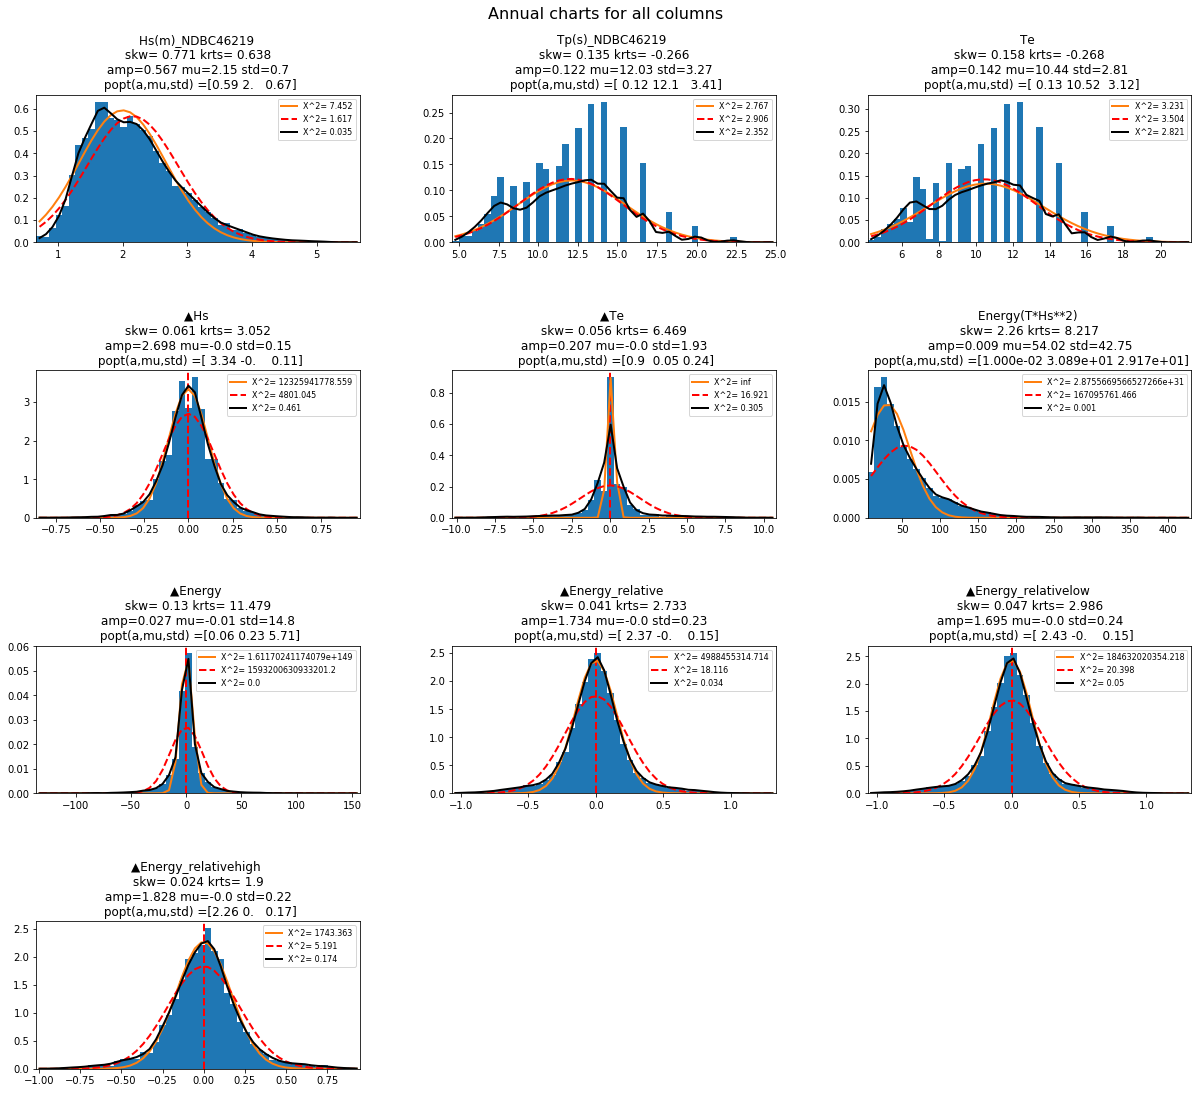

In [41]:
#annual histogramming 

df_hist_test(nd)

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: overflow encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


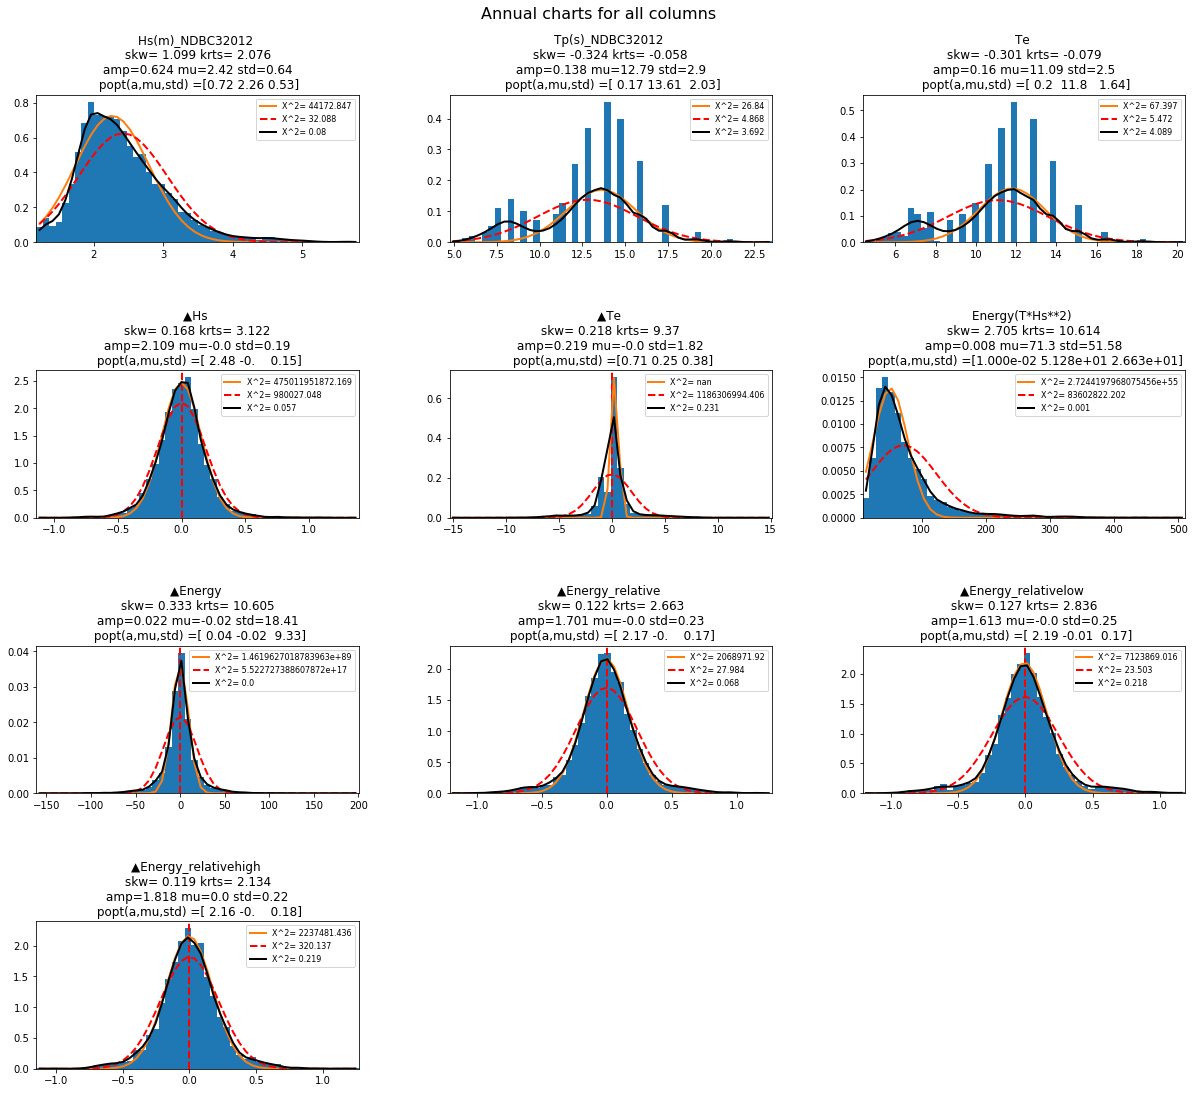

In [46]:
#ndbc different buoy

#annual histogramming 

df_hist_test(nd2)

In [116]:
df_hist_monthly(nd2)

KeyError: 1

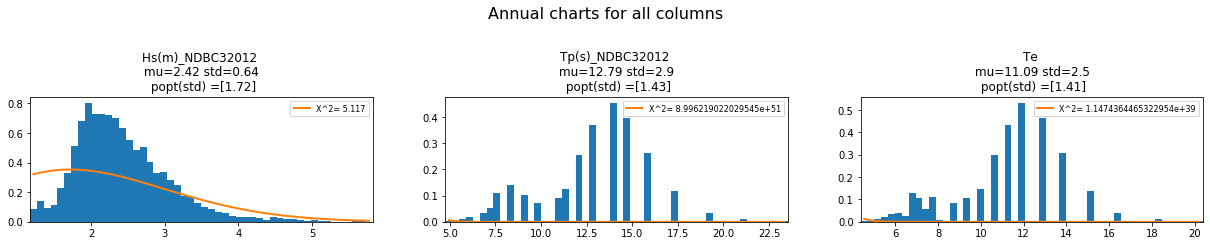

In [114]:
df_Rayleigh_histFit(nd2)

In [113]:
def hist_combine(df1,df2, monthly=False):
    
    #number of charts
    k = min(len(df1.columns),len(df2.columns))
    #number of chart columns for representing
    fig_cols = 3
    #number of chart rows for representing
    m = (k - 1) // fig_cols + 1
    
    fig = plt.figure(figsize=(fig_cols * 6, m * 4))   #dpi=300
        
    for i, (name, col) in enumerate(df1.iteritems() if len(df1.columns)<=len(df2.columns) else df2.iteritems()):       
        col1 = df1[df1.columns[i]]
        col2 = df2[df2.columns[i]]
        col1=col1.dropna()
        col2=col2.dropna()
        ax = fig.add_subplot(m, fig_cols, i+1)

        if not (col1.empty or col2.empty): 
            col= col.astype(float)
            #normalize
            #col = (col - col.min()) / (col.max() - col.min())
            # Fit to normal distribution
            (mu1, sigma1) = stats.norm.fit(col1)
            (mu2, sigma2) = stats.norm.fit(col2)
            
            # the histogram of the data
            n1, bins1, patches1 = ax.hist(df1[df1.columns[i]], bins=50, alpha=0.4, density=True, label=1)    
            n2, bins2, patches2 = ax.hist(df2[df2.columns[i]], bins=50, alpha=0.2, density=True, label = 2)
            #ax.axvline(x=0, color='r', linestyle='dashed', linewidth=2)       
            ax.set_xlim(min(min(bins1),min(bins2)),max(max(bins1),max(bins2)))            
            
            bin_width1 = bins1[1]-bins1[0]
            bins_middle1 = ((bins1[1:]+bins1[:-1])/2)
            bin_count1 = len(bins1)-1
            
            bin_width2 = bins2[1]-bins2[0]
            bins_middle2 = ((bins2[1:]+bins2[:-1])/2)
            bin_count2 = len(bins2)-1

            amp1 = n1.max()
            amp2 = n2.max()
            popt1, pcov1 = optimize.curve_fit(gaussian, bins_middle1, n1, p0=[amp1, mu1, sigma1])
            popt2, pcov2 = optimize.curve_fit(gaussian, bins_middle2, n2, p0=[amp2, mu2, sigma2])
            
            gauss1 = gaussian(bins_middle1, *popt1)
            gauss2 = gaussian(bins_middle2, *popt2)
            plt.plot(bins_middle1, gauss1, lw=2, label='1.X^2= ' + str(round(stats.chisquare(n1,gauss1)[0],3)))
            plt.plot(bins_middle2, gauss2, lw=2, label='2.X^2= ' + str(round(stats.chisquare(n2,gauss2)[0],3)))

            ax.set_title(name + ' mu=' + str(round(mu1,2)) + str(round(mu2,2)) + ' std=' + str(round(sigma1,2))
                         + str(round(sigma2,2)) + ' \n popt(mu,std) =' + str(popt1.round(2)) + str(popt2.round(2)))
            
            plt.legend(prop={'size': 8})

    #if len(df.groupby(df.index.month)) == 1:
    if(monthly == True):
        fig.suptitle(str(calendar.month_abbr[(df1.index.month)[0]]), fontsize=16)
    else:
        fig.suptitle('Annual charts for all columns', fontsize=16)
    #plt.show()
    fig.tight_layout(pad=5.0)

    return

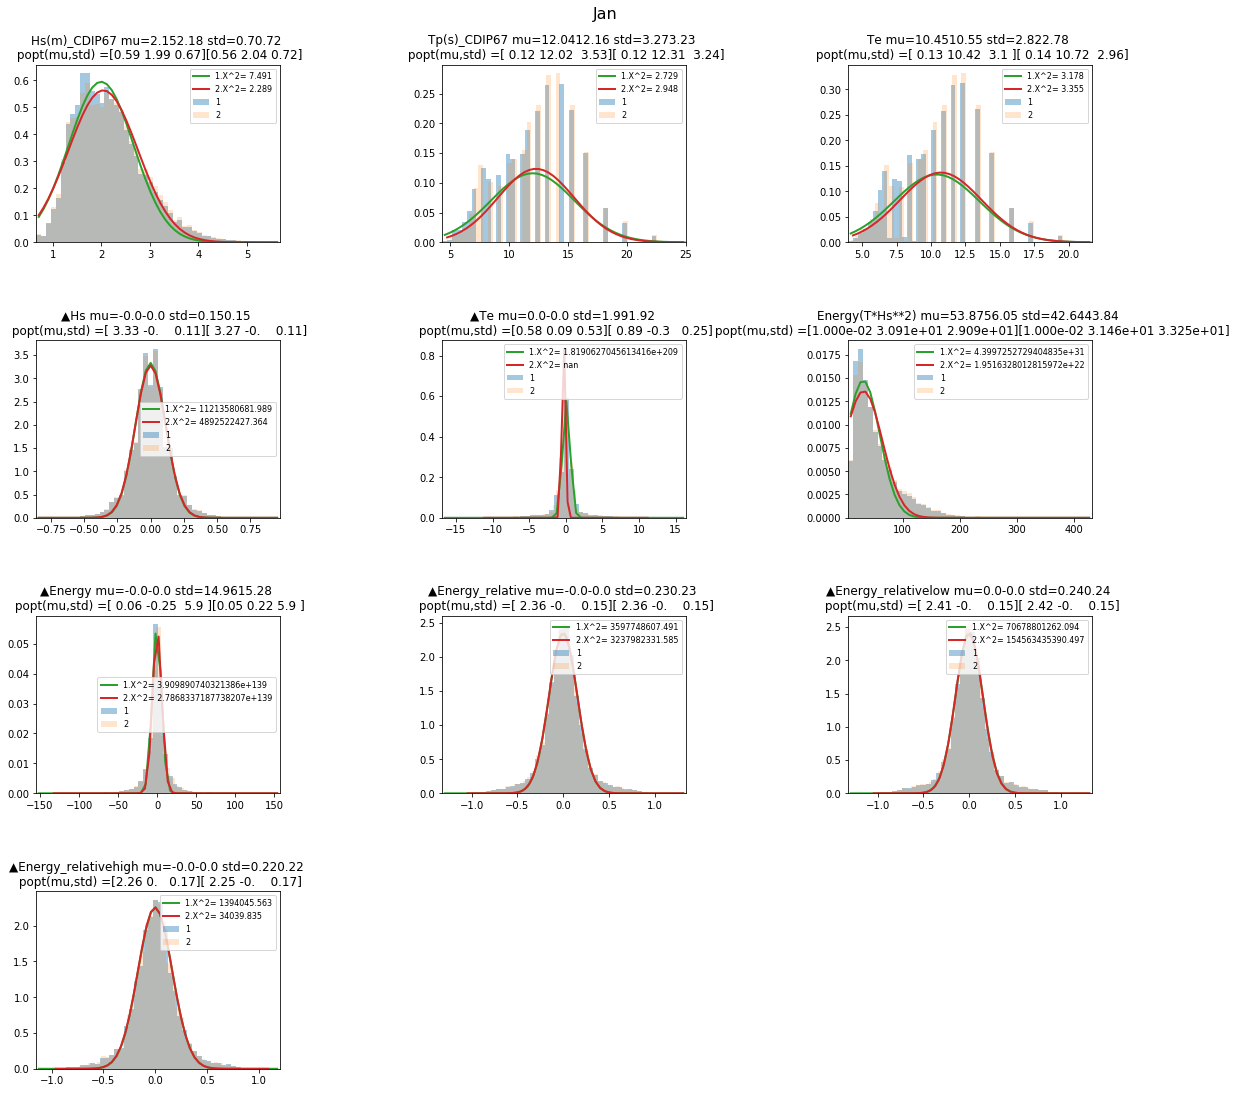

In [58]:
hist_combine(cd,emd)

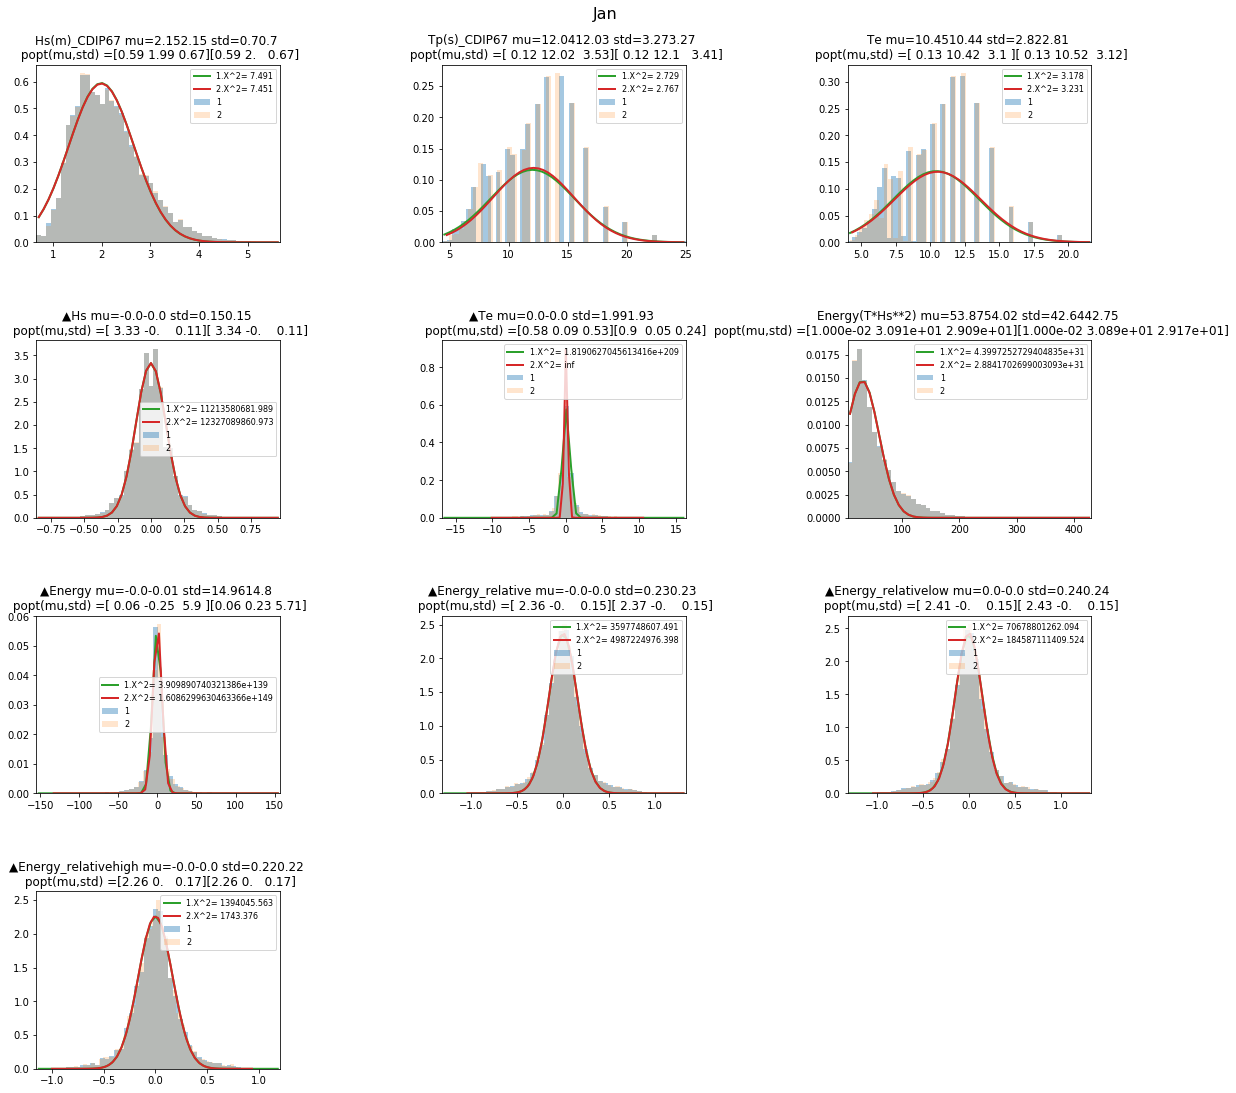

In [59]:
hist_combine(cd,nd)

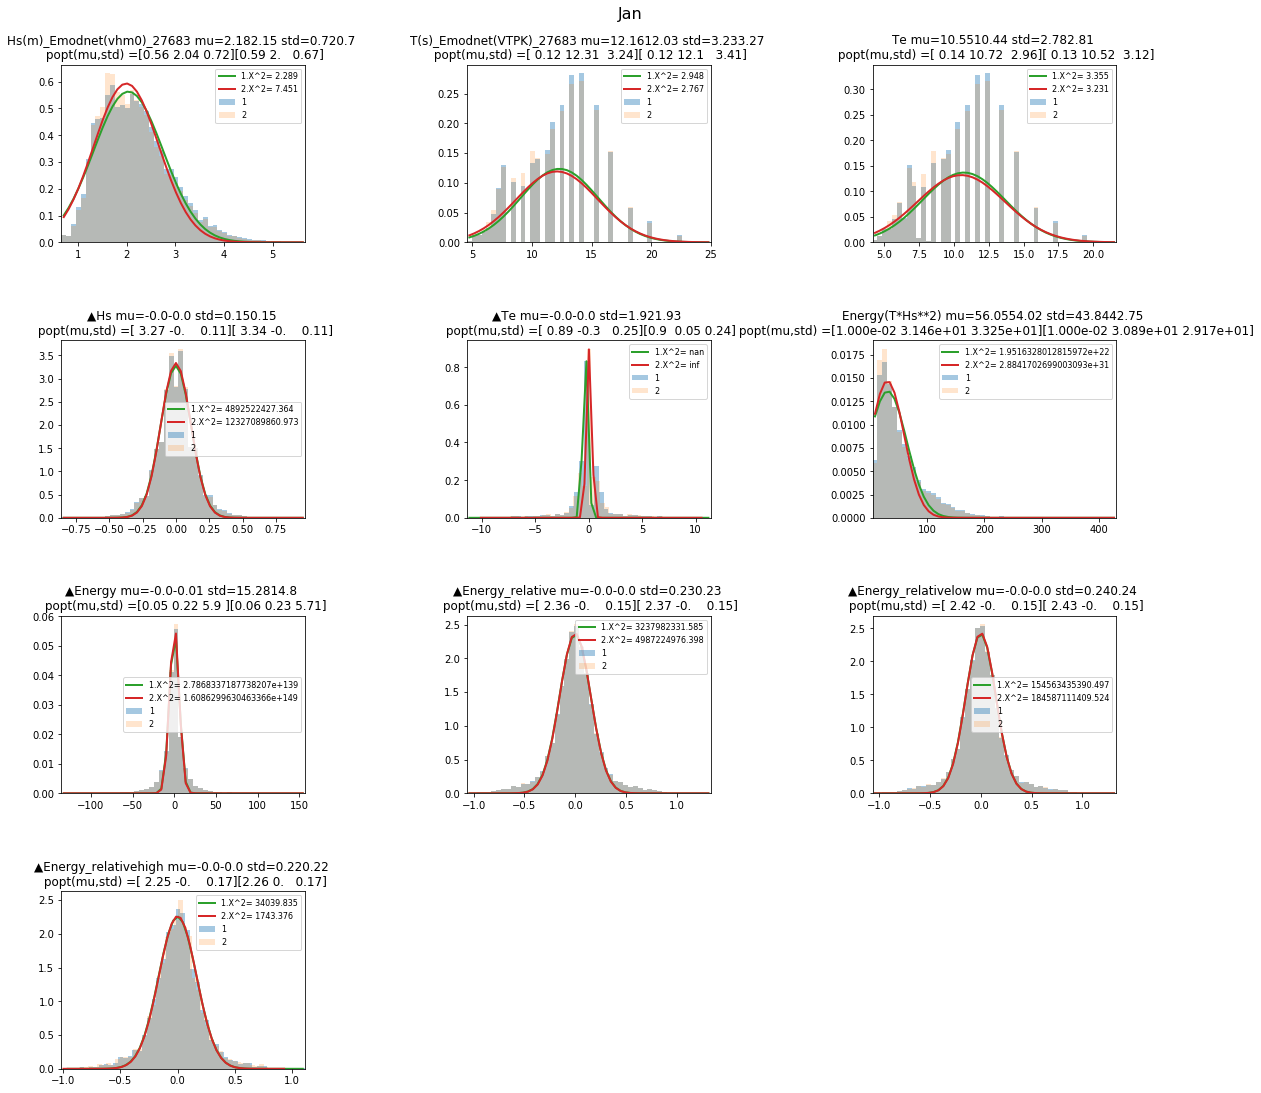

In [60]:
hist_combine(emd,nd)

In [15]:
def find_anomalies(df, col_name):
    outliers = pd.DataFrame()
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(df[col_name])
    data_mean = np.mean(df[col_name])
    anomaly_cut_off = data_std * 4

    lower_limit  = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    print('data length= ' + str(len(df)))
    print('data std= ' + str(data_std))
    print('mean value= ' + str(data_mean))
    print('anomaly cut off = ' + str(anomaly_cut_off))
    print('lower limit= ' + str(lower_limit))
    print('upper limit= ' + str(upper_limit))

    #Find outliers
    for i,r in df.iterrows():
        if r[col_name] > upper_limit or r[col_name] < lower_limit:
            outliers = pd.DataFrame(outliers.append(r))
    print(len(outliers))
    return outliers

In [16]:
def find_anomalies(data):
    outliers = []
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3

    lower_limit  = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    print('data length' + len(data))
    print('data std= ' + str(data_std))
    print('mean value= ' + str(data_mean))
    print('anomaly cut off = ' + str(anomaly_cut_off))
    print('lower limit= ' + str(lower_limit))
    print('upper limit= ' + str(upper_limit))

    #Find outliers
    for val in data:
        if val > upper_limit or val < lower_limit:
            outliers.append(val)
    print(len(outliers))
    return outliers

In [19]:
find_anomalies(cd, '▲Energy_relative')

data length= 17520
data std= 0.235998232766856
mean value= -3.6600912476629624e-05
anomaly cut off = 0.943992931067424
lower limit= -0.9440295319799006
upper limit= 0.9439563301549474
65


Energy(T*Hs**2)  Hs(m)_CDIP67  Tp(s)_CDIP67  \
2011-01-13 13:30:00+00:00         7.077856          1.16          5.26   
2011-01-13 16:00:00+00:00        20.236069          1.19         14.29   
2011-01-13 19:00:00+00:00         7.828984          1.22          5.26   
2011-01-14 23:30:00+00:00        17.824296          1.58          7.14   
2011-01-15 00:00:00+00:00        55.826163          1.83         16.67   
...                                    ...           ...           ...   
2011-10-12 03:30:00+00:00        42.357168          2.52          6.67   
2011-10-12 04:30:00+00:00       137.288000          2.62         20.00   
2011-10-12 08:30:00+00:00        41.126400          2.40          7.14   
2011-10-12 09:00:00+00:00       135.200000          2.60         20.00   
2011-10-21 05:30:00+00:00         9.455625          1.23          6.25   

                             ▲Energy  ▲Energy_relative   ▲Hs     ▲T  
2011-01-13 13:30:00+00:00 -12.762516         -0.948243 -0.06  -8.07  
2011-01-13 16:00:00+00:00  13.508069          1.001931  0.03   9.29  
2011-01-13 19:00:00+00:00 -15.583752         -0.997624 -0.06  -9.03  
2011-01-14 23:30:00+00:00 -33.812696         -0.973570 -0.18  -9.53  
2011-01-15 00:00:00+00:00  38.001867          1.031952  0.25   9.53  
...                              ...               ...   ...    ...  
2011-10-12 03:30:00+00:00 -85.660832         -1.005555 -0.01 -13.33  
2011-10-12 04:30:00+00:00  90.495296          0.983213  0.06  12.86  
2011-10-12 08:30:00+00:00 -76.971600         -0.966832 -0.03 -12.86  
2011-10-12 09:00:00+00:00  94.073600          1.067039  0.20  12.86  
2011-10-21 05:30:00+00:00 -20.260073         -1.034434 -0.16  -9.13  

[65 rows x 7 columns]

In [ ]:
def df_energy(df):
    #J = ρ * g**2 * Te * Hs**2 /(64*math.pi)
    #Te * Hs**2
    hs_col = df.columns[0]
    t_col = df.columns[1]
    df_new['Energy(T*Hs**2)'] = df[t_col] * df[hs_col]**2
    df_new['▲Energy'] = df_new['Energy(T*Hs**2)'].diff()
    #df['▲Energy(%)'] = df['Energy(T*Hs**2)'].pct_change(fill_method=None)
    return df_new
#function takes dataframe as parameter and uses partial energy formula by using height and period.
#Calculates the energy columns differences between rows.
#Percentage change of energy between rows is also calculated..

def df_energy(df):
    #J = ρ * g**2 * Te * Hs**2 /(64*math.pi)
    #Te * Hs**2
    df_new = pd.DataFrame()
    hs_col = df.columns[0]
    t_col = df.columns[1]
    df_new['Energy(T*Hs**2)'] = df[t_col] * df[hs_col]**2
    df_new['▲Energy'] = df_new['Energy(T*Hs**2)'].diff()
    #df['▲Energy(%)'] = df['Energy(T*Hs**2)'].pct_change(fill_method=None)
    return df_new
emodnet = df_delta(emodnet)
df_energy(emodnet)
#function takes dataframe as parameter and uses partial energy formula by using height and period.
#Calculates the energy columns differences between rows.
#Percentage change of energy between rows is also calculated..

In [ ]:
df_new = pd.DataFrame()

df = df_energy(df)
df = df[df.columns[-1:]]
df['is nan'] = df.isna()

#df.resample('M').mean().plot()
df_res = df[df.columns[-2:]].resample('M')
print(df_res)
df[df.columns[0]] = df_res[0].mean()
df[df.columns[1]] = df_res[1].sum()
return df
df_new['avg difference'] = df_res.mean()
#print(df_res)
#df.iloc[:,-1]
#x=df_res.agg(pd.isna)
#print(type(x))
#print(df_res.apply(pd.isna).agg(np.sum))
df_new['nan count'] = df_res.apply(pd.isna).resample('M').sum()
#print(df_res.agg(pd.isnull))

#to find nan values... df.isna().sum() returns nan for each column. Both hs and period should be nan or have values.
#just in case of an inaccuracy it will take the max nan count
#max(df_res.isna().sum()[0],df_res.isna().sum()[1])

#return df_new

In [25]:
aa = pd.DataFrame({'x': [1, 12, 2, 5]})


0     1
1    12
2     2
Name: x, dtype: int64

In [33]:
y = norm.pdf(aa['x'])
y

array([2.41970725e-01, 2.14638374e-32, 5.39909665e-02, 1.48671951e-06])

In [14]:
print(preprocessing.normalize(aa))



[[1.]
 [1.]
 [1.]
 [1.]]


In [22]:
norm.ppf(aa)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(aa)

#df['col']=(df['col']-df['col'].min())/(df['col'].max()-df['col'].min())
xx= (aa-aa.min())/(aa.max()-aa.min())


x
0  0.000000
1  1.000000
2  0.090909
3  0.363636

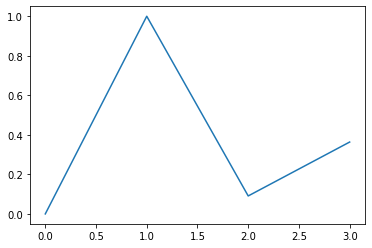

In [28]:
plt.plot(xx)

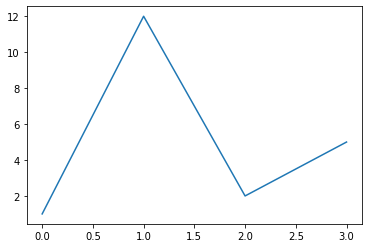

In [23]:
plt.plot(aa)

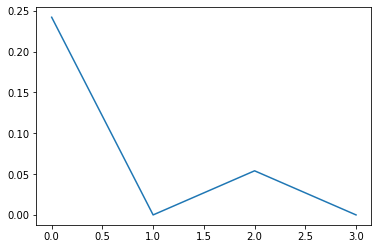

In [27]:


norm()

plt.plot(norm.pdf(aa))


In [3]:
aa = pd.DataFrame({'x': [0.6, 0.5, 0.13]})

In [6]:
norm.pdf(aa['x'])

array([0.3332246 , 0.35206533, 0.39558542])

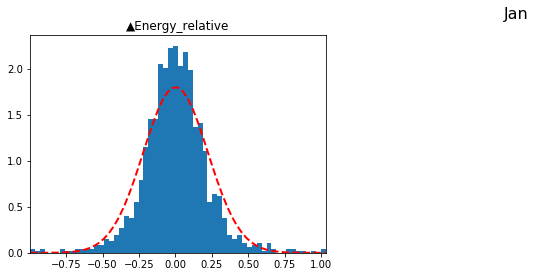

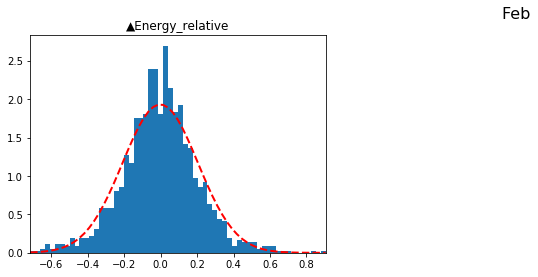

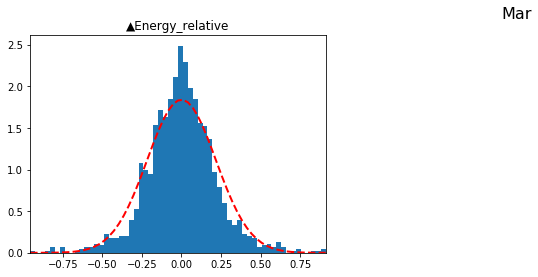

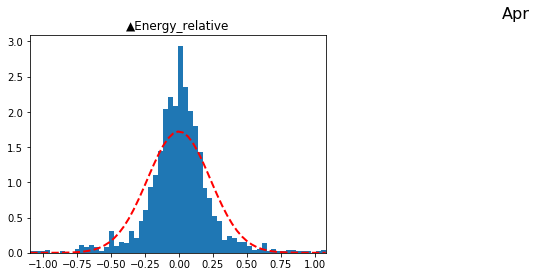

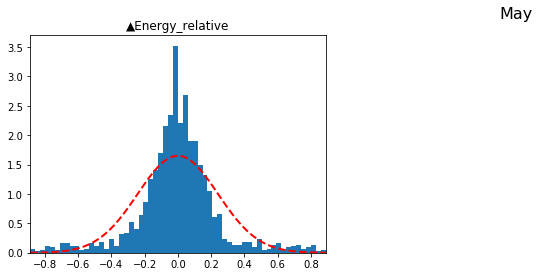

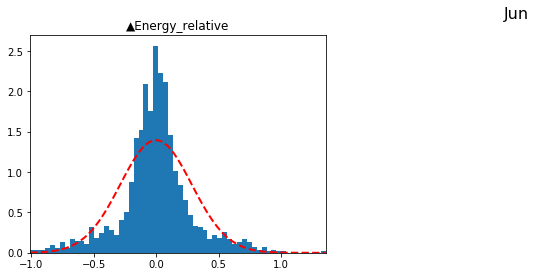

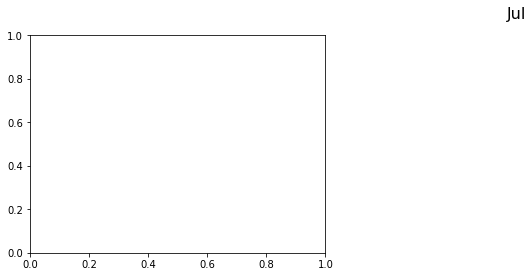

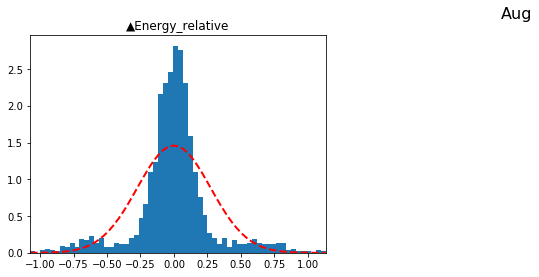

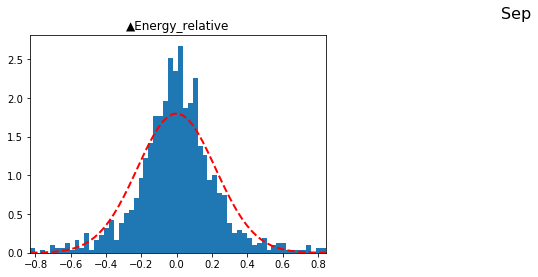

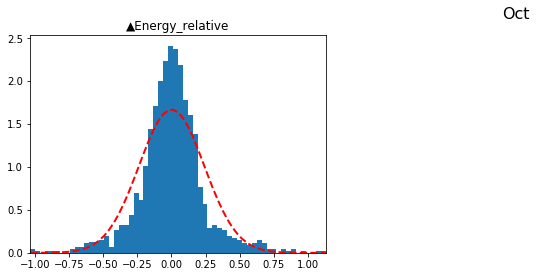

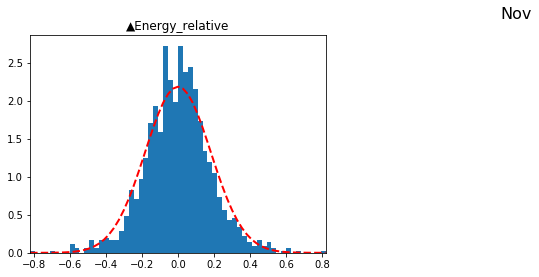

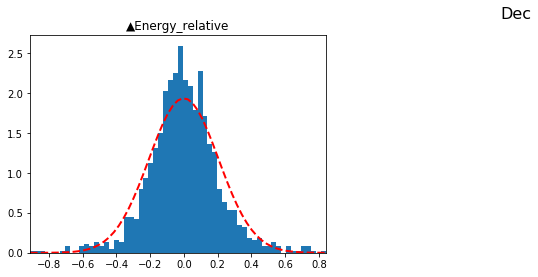

In [22]:
df_hist_monthly(pd.DataFrame(emd['▲Energy_relative']))